# Notebook: Estudo da variação da mfft para sinais com e sem ruído

Descrição:

Neste notebook apresenta-se os resultados do estudo da variação da mfft para sinais com e sem ruído. Sinais simulados são utilizados para gerar espectrogramas (Seção 1.0) que são observados juntamente com métricas quantitativas que auxiliam na caracterização do espectrograma com relação a variação do hop.

Como resultados principais (Seção 2.0) caracteriza-se o aumento da resolução frequencial com mfft, as mudanças visuais observadas no espectrograma, a influência da mfft no comprimento e na largura do dos picos principais do espectrograma, e o impacto (insignificante) da mfft nas listras dos picos do espectrograma.

## 0.0 Definições

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
from scipy.signal.windows import hann
from matplotlib import gridspec
import json

In [2]:
import utils
import functions_for_param_study as funcstud

## 1.0 Aquisição dos sinais simulados, geração dos espectrogramas e carregamento das métricas quantitativas:

In [3]:
qntty = 50
test_not_save = True

In [4]:
#Import data obtained on EditedMRS_Reconstruction_Challenge github -- Ground-truths
with h5py.File('../sample_data.h5') as hf:
  print(hf.keys())
  gt_fids = hf["ground_truth_fids"][()][:qntty]
  ppm = hf["ppm"][()][:qntty]
  t = hf["t"][()][:qntty]
  print(gt_fids.shape)
  print(ppm.shape)
  print(t.shape)

<KeysViewHDF5 ['ground_truth_fids', 'ppm', 't']>
(50, 2048, 2)
(50, 2048)
(50, 2048)


In [5]:
dwelltime = t[0,1]-t[0,0]
bandwidth = 1/dwelltime
N = gt_fids.shape[1]

#gts
spectra_gt_fids = np.fft.fftshift(np.fft.ifft(gt_fids,n=N,axis = 1), axes = 1)
spectra_gt_diff = spectra_gt_fids[:,:,1] - spectra_gt_fids[:,:,0]
freq = np.flip(np.fft.fftshift(np.fft.fftfreq(N, d = dwelltime)))

#to get ppm axis
idx_min = np.real(spectra_gt_diff[0,:]).argmin()
idx_max = np.real(spectra_gt_diff[0,:]).argmax()
#p = a*f + b
a = (ppm[0,idx_max] - ppm[0,idx_min])/(freq[idx_max]-freq[idx_min])
b = ppm[0,idx_max] - a*freq[idx_max]
#ppm_aux = b + freq*a

In [6]:
corrupted_fids = utils.create_corrupted_fids(gt=gt_fids,t=t,std_base=6,std_var=2,ntransients=160)

In [7]:
#generation of the STFTs
mfft_ = np.arange(32,1024,20)
window_ = []
for i in range(mfft_.shape[0]):
    window_.append(hann(int(mfft_[i]),sym=True))
hop_ = 8
norm_ = 'abs'
spgram_mfft_gt = {}
spgram_mfft_ns = {}
for i in range(mfft_.shape[0]):
    spgram_gt, freq_spect, ppm_spect, t_spect = utils.get_normalized_spectrogram(fids=gt_fids[:,:,1]-gt_fids[:,:,0],bandwidth=bandwidth,window=window_[i],mfft=int(mfft_[i]),hop=hop_,norm=norm_,correct_time=True,a=a,b=b)
    spgram_mfft_gt['mfft_'+str(mfft_[i])] = [spgram_gt, freq_spect, ppm_spect, t_spect]
    spgram_ns, freq_spect, ppm_spect, t_spect = utils.get_normalized_spectrogram(fids=np.mean(corrupted_fids[:,:,1,:]-corrupted_fids[:,:,0,:],axis=2),bandwidth=bandwidth,window=window_[i],mfft=int(mfft_[i]),hop=hop_,norm=norm_,correct_time=True,a=a,b=b)
    spgram_mfft_ns['mfft_'+str(mfft_[i])] = [spgram_ns, freq_spect, ppm_spect, t_spect]

Algumas colunas e linhas de interesse na análise dos espectrogramas:

In [8]:
list_of_t_spects = []
list_of_ppm_spects = []
for i in range(mfft_.shape[0]):
    list_of_t_spects.append(spgram_mfft_gt['mfft_'+str(mfft_[i])][-1])
    list_of_ppm_spects.append(spgram_mfft_gt['mfft_'+str(mfft_[i])][2])
idx_time_0d05 = utils.give_idx_time_point_for_different_time_arrays(list_time_arrays=list_of_t_spects,time_point=0.05)
idx_time_0d4 = utils.give_idx_time_point_for_different_time_arrays(list_time_arrays=list_of_t_spects,time_point=0.4)
idx_time_0d6 = utils.give_idx_time_point_for_different_time_arrays(list_time_arrays=list_of_t_spects,time_point=0.6)
idx_freq_0ppm = utils.give_idx_ppm_point_for_different_ppm_arrays(list_ppm_arrays=list_of_ppm_spects,ppm_point=0)
idx_freq_1ppm = utils.give_idx_ppm_point_for_different_ppm_arrays(list_ppm_arrays=list_of_ppm_spects,ppm_point=1)
idx_freq_4ppm = utils.give_idx_ppm_point_for_different_ppm_arrays(list_ppm_arrays=list_of_ppm_spects,ppm_point=4)
idx_freq_8ppm = utils.give_idx_ppm_point_for_different_ppm_arrays(list_ppm_arrays=list_of_ppm_spects,ppm_point=8)
idx_freq_8d5ppm = utils.give_idx_ppm_point_for_different_ppm_arrays(list_ppm_arrays=list_of_ppm_spects,ppm_point=8.5)
idx_freq_NAA = utils.give_idx_ppm_point_for_different_ppm_arrays(list_ppm_arrays=list_of_ppm_spects,ppm_point=2.02)
idx_freq_GABA = utils.give_idx_ppm_point_for_different_ppm_arrays(list_ppm_arrays=list_of_ppm_spects,ppm_point=3.00)
idx_freq_Glx = utils.give_idx_ppm_point_for_different_ppm_arrays(list_ppm_arrays=list_of_ppm_spects,ppm_point=3.75)
idx_freq_1d9ppm = utils.give_idx_ppm_point_for_different_ppm_arrays(list_ppm_arrays=list_of_ppm_spects,ppm_point=1.9)
idx_freq_2d12ppm = utils.give_idx_ppm_point_for_different_ppm_arrays(list_ppm_arrays=list_of_ppm_spects,ppm_point=2.12)
idx_freq_3d12ppm = utils.give_idx_ppm_point_for_different_ppm_arrays(list_ppm_arrays=list_of_ppm_spects,ppm_point=3.12)
idx_freq_2d9ppm = utils.give_idx_ppm_point_for_different_ppm_arrays(list_ppm_arrays=list_of_ppm_spects,ppm_point=2.9)
idx_freq_3d87ppm = utils.give_idx_ppm_point_for_different_ppm_arrays(list_ppm_arrays=list_of_ppm_spects,ppm_point=3.87)
idx_freq_3d64ppm = utils.give_idx_ppm_point_for_different_ppm_arrays(list_ppm_arrays=list_of_ppm_spects,ppm_point=3.64)
idx_freq_m2ppm = utils.give_idx_ppm_point_for_different_ppm_arrays(list_ppm_arrays=list_of_ppm_spects,ppm_point=-2)
idx_freq_4d6ppm = utils.give_idx_ppm_point_for_different_ppm_arrays(list_ppm_arrays=list_of_ppm_spects,ppm_point=4.6)
idx_freq_4d8ppm = utils.give_idx_ppm_point_for_different_ppm_arrays(list_ppm_arrays=list_of_ppm_spects,ppm_point=4.8)

### 1.1 Carregamento das métricas quantitativas

In [9]:
gt_metrics = utils.read_txt_file_wth_qnttive_metrics('./quantitative_metrics_saved_data/quantitative_metrics_no_noise_mfft_variation_hop_8.txt')
ns_metrics = utils.read_txt_file_wth_qnttive_metrics('./quantitative_metrics_saved_data/quantitative_metrics_with_noise_mfft_variation_hop_8.txt')

In [10]:
metrics_names = list(gt_metrics.keys())

## 2.0 Resultados Principais

### 2.1 Aumento da resolução frequencial

O número de linhas do espectrograma cresce linearmente com o aumento de mfft. Há, portanto, uma melhora na resolução frequencial.

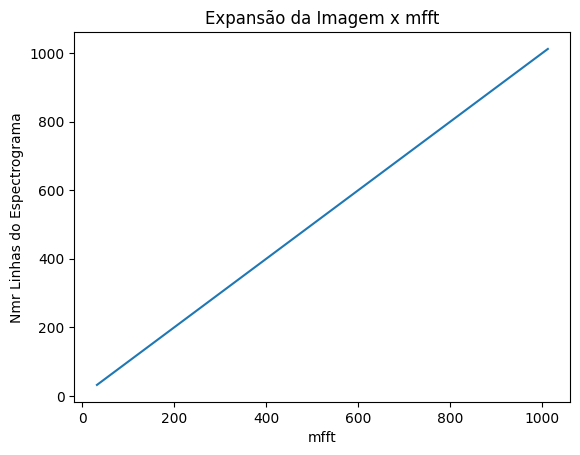

In [12]:
info_expansion = []
for i in range(len(mfft_)):
    info_expansion.append(spgram_mfft_gt['mfft_'+str(mfft_[i])][0].shape[1])

plt.plot(mfft_,info_expansion)
plt.ylabel('Nmr Linhas do Espectrograma')
plt.xlabel('mfft')
plt.title('Expansão da Imagem x mfft')
if test_not_save == False:
    plt.savefig('./relatorio_imagens/imagens_mfft/spgram_varying_mfft_gt_increase_in_lines.png')

### 2.2 Análise Visual

Espectrogramas sem ruído: Picos ficam mais finos conforme mfft aumenta. Para mfft muito baixo (ex mfft = 52), não tem formato de pico e não se nota os picos de intensidade mais baixa. Eles aparecem a partir da imagem obtida com mfft = 272, e se mantém idênticos nas demais. Listras dos picos são iguais.

Espectrogramas com ruído: faixas de oscilação do ruído são mais difíceis de serems distinguidas para mfft baixo, mas parecem idênticas nas demais. Hipótese: a largura das faixas de ruído se estabiliza antes da largura dos picos principais. A verificar.

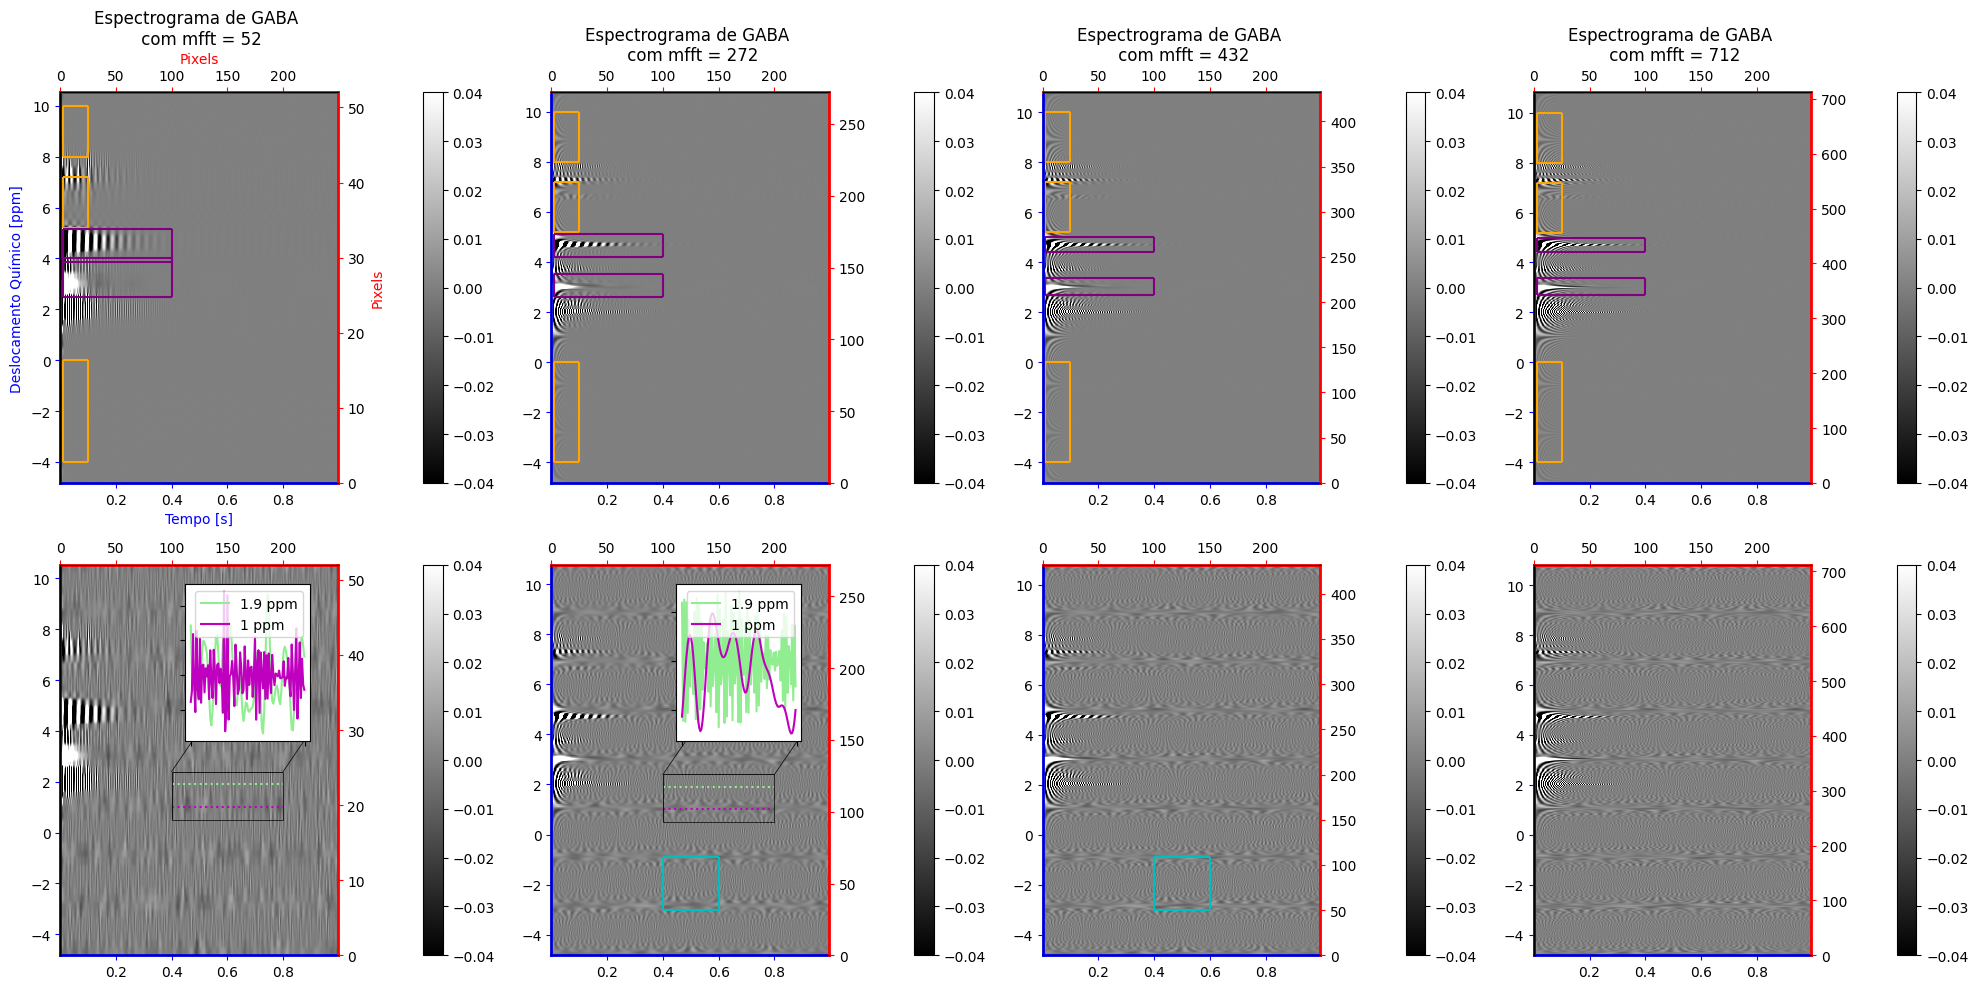

In [13]:
fig,ax = plt.subplots(2,4,figsize=(20,10))
im = ax.flat[0].imshow(np.real(spgram_mfft_gt['mfft_'+str(mfft_[1])][0][0,:,:]), origin='lower', aspect='auto',cmap='gray',vmin=-0.04,vmax=0.04,
             extent = (spgram_mfft_gt['mfft_'+str(mfft_[1])][-1][0],spgram_mfft_gt['mfft_'+str(mfft_[1])][-1][-1],spgram_mfft_gt['mfft_'+str(mfft_[1])][2][-1],spgram_mfft_gt['mfft_'+str(mfft_[1])][2][0]))
im = ax.flat[1].imshow(np.real(spgram_mfft_gt['mfft_'+str(mfft_[12])][0][0,:,:]), origin='lower', aspect='auto',cmap='gray',vmin=-0.04,vmax=0.04,
             extent = (spgram_mfft_gt['mfft_'+str(mfft_[12])][-1][0],spgram_mfft_gt['mfft_'+str(mfft_[12])][-1][-1],spgram_mfft_gt['mfft_'+str(mfft_[12])][2][-1],spgram_mfft_gt['mfft_'+str(mfft_[12])][2][0]))
im = ax.flat[2].imshow(np.real(spgram_mfft_gt['mfft_'+str(mfft_[20])][0][0,:,:]), origin='lower', aspect='auto',cmap='gray',vmin=-0.04,vmax=0.04,
             extent = (spgram_mfft_gt['mfft_'+str(mfft_[20])][-1][0],spgram_mfft_gt['mfft_'+str(mfft_[20])][-1][-1],spgram_mfft_gt['mfft_'+str(mfft_[20])][2][-1],spgram_mfft_gt['mfft_'+str(mfft_[20])][2][0]))
im = ax.flat[3].imshow(np.real(spgram_mfft_gt['mfft_'+str(mfft_[34])][0][0,:,:]), origin='lower', aspect='auto',cmap='gray',vmin=-0.04,vmax=0.04,
             extent = (spgram_mfft_gt['mfft_'+str(mfft_[34])][-1][0],spgram_mfft_gt['mfft_'+str(mfft_[34])][-1][-1],spgram_mfft_gt['mfft_'+str(mfft_[34])][2][-1],spgram_mfft_gt['mfft_'+str(mfft_[34])][2][0]))
im =ax.flat[4].imshow(np.real(spgram_mfft_ns['mfft_'+str(mfft_[1])][0][0,:,:]), origin='lower', aspect='auto',cmap='gray',vmin=-0.04,vmax=0.04,
             extent = (spgram_mfft_gt['mfft_'+str(mfft_[1])][-1][0],spgram_mfft_gt['mfft_'+str(mfft_[1])][-1][-1],spgram_mfft_gt['mfft_'+str(mfft_[1])][2][-1],spgram_mfft_gt['mfft_'+str(mfft_[1])][2][0]))
im =ax.flat[5].imshow(np.real(spgram_mfft_ns['mfft_'+str(mfft_[12])][0][0,:,:]), origin='lower', aspect='auto',cmap='gray',vmin=-0.04,vmax=0.04,
             extent = (spgram_mfft_gt['mfft_'+str(mfft_[12])][-1][0],spgram_mfft_gt['mfft_'+str(mfft_[12])][-1][-1],spgram_mfft_gt['mfft_'+str(mfft_[12])][2][-1],spgram_mfft_gt['mfft_'+str(mfft_[12])][2][0]))
im = ax.flat[6].imshow(np.real(spgram_mfft_ns['mfft_'+str(mfft_[20])][0][0,:,:]), origin='lower', aspect='auto',cmap='gray',vmin=-0.04,vmax=0.04,
             extent = (spgram_mfft_gt['mfft_'+str(mfft_[20])][-1][0],spgram_mfft_gt['mfft_'+str(mfft_[20])][-1][-1],spgram_mfft_gt['mfft_'+str(mfft_[20])][2][-1],spgram_mfft_gt['mfft_'+str(mfft_[20])][2][0]))
im = ax.flat[7].imshow(np.real(spgram_mfft_ns['mfft_'+str(mfft_[34])][0][0,:,:]), origin='lower', aspect='auto',cmap='gray',vmin=-0.04,vmax=0.04,
             extent = (spgram_mfft_gt['mfft_'+str(mfft_[34])][-1][0],spgram_mfft_gt['mfft_'+str(mfft_[34])][-1][-1],spgram_mfft_gt['mfft_'+str(mfft_[34])][2][-1],spgram_mfft_gt['mfft_'+str(mfft_[34])][2][0]))


mfft_plot = [1,12,20,34,1,12,20,34]
for i in range(2):
    for j in range(4):
        fig.colorbar(im, ax=ax[i,j], pad = 0.2)
for i in range(8):
    par1 = ax.flat[i].twiny()  # Additional x-axis
    par2 = ax.flat[i].twinx()  # Additional y-axis
    if i < 4:
        ax.flat[i].set_title('Espectrograma de GABA \n com mfft = '+str(mfft_[mfft_plot[i]]))
    if  i == 0:
        ax.flat[i].set_xlabel('Tempo [s]')
        ax.flat[i].set_ylabel('Deslocamento Químico [ppm]')
        ax.flat[i].xaxis.label.set_color('b')
        ax.flat[i].yaxis.label.set_color('b')
    ax.flat[i].spines['left'].set_visible(True)
    ax.flat[i].spines['bottom'].set_visible(True)
    ax.flat[i].spines['left'].set_color('b')
    ax.flat[i].spines['bottom'].set_color('b')
    ax.flat[i].spines['left'].set_linewidth(2)
    ax.flat[i].spines['bottom'].set_linewidth(2)
    # Set the position of the additional axes
    par1.spines['top'].set_position(('axes', 1))
    par2.spines['right'].set_position(('axes', 1))
    # Customize the additional axes
    par1.set_xlim(0,spgram_mfft_gt['mfft_'+str(mfft_[mfft_plot[i]])][0].shape[2])
    par2.set_ylim(0,spgram_mfft_gt['mfft_'+str(mfft_[mfft_plot[i]])][0].shape[1])
    if i == 0:
        par1.set_xlabel("Pixels")
        par2.set_ylabel("Pixels")
        par1.xaxis.label.set_color('r')
        par2.yaxis.label.set_color('r')
    # Turn off unwanted spines for clarity
    par1.spines['top'].set_visible(True)
    par2.spines['right'].set_visible(True)
    par2.spines['right'].set_color('r')
    par1.spines['top'].set_color('r')
    par2.spines['right'].set_linewidth(2)
    par1.spines['top'].set_linewidth(2)
    # Synchronize the tick positions of the host and the twin axes
    ax.flat[i].tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=True, labeltop=False,color='b')
    par1.tick_params(axis='x', which='both', bottom=False, top=True, labelbottom=False, labeltop=True,color ='r')
    ax.flat[i].tick_params(axis='y', which='both', left=True, right=False, labelleft=True, labelright=False,color='b')
    par2.tick_params(axis='y', which='both', left=False, right=True, labelleft=False, labelright=True,color='r')

for i in range(4):
    #less intense peaks
    ax.flat[i].hlines(-4,0.01,0.1,color='orange')
    ax.flat[i].hlines(0,0.01,0.1,color='orange')
    ax.flat[i].vlines(0.01,-4,0,color='orange')
    ax.flat[i].vlines(0.1,-4,0,color='orange')
    ax.flat[i].hlines(5.2,0.01,0.1,color='orange')
    ax.flat[i].hlines(7.2,0.01,0.1,color='orange')
    ax.flat[i].vlines(0.01,5.2,7.2,color='orange')
    ax.flat[i].vlines(0.1,5.2,7.2,color='orange')
    ax.flat[i].hlines(8,0.01,0.1,color='orange')
    ax.flat[i].hlines(10,0.01,0.1,color='orange')
    ax.flat[i].vlines(0.01,8,10,color='orange')
    ax.flat[i].vlines(0.1,8,10,color='orange')
    #stripes
#peaks
ax.flat[0].hlines(3.85,0.01,0.4,color='purple')
ax.flat[0].hlines(5.15,0.01,0.4,color='purple')
ax.flat[0].vlines(0.01,3.85,5.15,color='purple')
ax.flat[0].vlines(0.4,3.85,5.15,color='purple')
ax.flat[0].hlines(2.5,0.01,0.4,color='purple')
ax.flat[0].hlines(4,0.01,0.4,color='purple')
ax.flat[0].vlines(0.01,2.5,4,color='purple')
ax.flat[0].vlines(0.4,2.5,4,color='purple')
#peaks
ax.flat[1].hlines(4.2,0.01,0.4,color='purple')
ax.flat[1].hlines(5.1,0.01,0.4,color='purple')
ax.flat[1].vlines(0.01,4.2,5.1,color='purple')
ax.flat[1].vlines(0.4,4.2,5.1,color='purple')
ax.flat[1].hlines(2.6,0.01,0.4,color='purple')
ax.flat[1].hlines(3.5,0.01,0.4,color='purple')
ax.flat[1].vlines(0.01,2.6,3.5,color='purple')
ax.flat[1].vlines(0.4,2.6,3.5,color='purple')
#peaks
ax.flat[2].hlines(4.4,0.01,0.4,color='purple')
ax.flat[2].hlines(5,0.01,0.4,color='purple')
ax.flat[2].vlines(0.01,4.4,5,color='purple')
ax.flat[2].vlines(0.4,4.4,5,color='purple')
ax.flat[2].hlines(2.7,0.01,0.4,color='purple')
ax.flat[2].hlines(3.38,0.01,0.4,color='purple')
ax.flat[2].vlines(0.01,2.7,3.38,color='purple')
ax.flat[2].vlines(0.4,2.7,3.38,color='purple')
#peaks
ax.flat[3].hlines(4.4,0.01,0.4,color='purple')
ax.flat[3].hlines(5,0.01,0.4,color='purple')
ax.flat[3].vlines(0.01,4.4,5,color='purple')
ax.flat[3].vlines(0.4,4.4,5,color='purple')
ax.flat[3].hlines(2.7,0.01,0.4,color='purple')
ax.flat[3].hlines(3.38,0.01,0.4,color='purple')
ax.flat[3].vlines(0.01,2.7,3.38,color='purple')
ax.flat[3].vlines(0.4,2.7,3.38,color='purple')


#noise regions
axins1 = ax.flat[4].inset_axes([0.45, 0.55, 0.45, 0.4], xticklabels=[], yticklabels=[])
axins1.plot(np.real(spgram_mfft_ns['mfft_'+str(mfft_[3])][0][0,22,100:200]),color='lightgreen',label='1.9 ppm')
axins1.plot(np.real(spgram_mfft_ns['mfft_'+str(mfft_[3])][0][0,19,100:200]),color='m', label='1 ppm')
axins1.legend(loc='upper right')
ax.flat[4].hlines(1,0.4,0.8,color='m',linestyle='dotted')
ax.flat[4].hlines(1.9,0.4,0.8,color='lightgreen',linestyle='dotted')
ax.flat[4].hlines(0.5,0.4,0.8,color='black',linewidth=0.5)
ax.flat[4].hlines(2.4,0.4,0.8,color='black',linewidth=0.6)
ax.flat[4].vlines(0.4,0.5,2.4,color='black',linewidth=0.6)
ax.flat[4].vlines(0.8,0.5,2.4,color='black',linewidth=0.5)
ax.flat[4].plot([0.4,0.48],[2.4,3.7],color='black',linewidth=0.5)
ax.flat[4].plot([0.8,0.88],[2.4,3.7],color='black',linewidth=0.5)

axins1 = ax.flat[5].inset_axes([0.45, 0.55, 0.45, 0.4], xticklabels=[], yticklabels=[])
axins1.plot(np.real(spgram_mfft_ns['mfft_'+str(mfft_[12])][0][0,117,100:200]),color='lightgreen',label='1.9 ppm')
axins1.plot(np.real(spgram_mfft_ns['mfft_'+str(mfft_[12])][0][0,101,100:200]),color='m', label='1 ppm')
axins1.legend(loc='upper right')
ax.flat[5].hlines(1,0.4,0.8,color='m',linestyle='dotted')
ax.flat[5].hlines(1.9,0.4,0.8,color='lightgreen',linestyle='dotted')
ax.flat[5].hlines(0.5,0.4,0.8,color='black',linewidth=0.5)
ax.flat[5].hlines(2.4,0.4,0.8,color='black',linewidth=0.6)
ax.flat[5].vlines(0.4,0.5,2.4,color='black',linewidth=0.6)
ax.flat[5].vlines(0.8,0.5,2.4,color='black',linewidth=0.5)
ax.flat[5].plot([0.4,0.48],[2.4,3.7],color='black',linewidth=0.5)
ax.flat[5].plot([0.8,0.88],[2.4,3.7],color='black',linewidth=0.5)
for i in range(2):
    ax.flat[5+i].hlines(-3,0.4,0.6,color='c')
    ax.flat[5+i].hlines(-0.9,0.4,0.6,color='c')
    ax.flat[5+i].vlines(0.4,-3,-0.9,color='c')
    ax.flat[5+i].vlines(0.6,-3,-0.9,color='c')


plt.tight_layout()
if test_not_save == False:
    plt.savefig('./relatorio_imagens/imagens_mfft/spgram_varying_mfft_gt_and_noisy_image_examples.png')

#### 2.2.1 Visualização de espectrogramas concatenados:

Observando os espectrogramas concatenados no formato abaixo, tem-se uma melhor dimensão do aumento de linhas. O último espectrograma ocupa todas as linhas da imagem, os demais, como são menores, sofrem zero-padded. Nota-se como a quantidade de colunas é a mesma, mas o menor número de linhas comprime o espaço da imagem.

Nota-se que as linhas de ruído estão sempre nas mesmas posições. Equivalentemente, os picos de menor intensidade também não mudam de quantidade ou posição com o aumento de mfft.

Ao observar a magnitude do espectograma, parece que o decaimento de alguns picos fica ligeiramente mais lento com o aumento de mfft. Em outras palavras, apesar de todos os espectrogramas serem representados com a mesma quantidade de colunas, parece que alguns picos (GABA, por ex) ficam mais longos (ocupam mais colunas) antes de decair. Marcações em magenta indicam a coluna, onde visualmente, tem-se o decaimento do pico de GABA, e, em ciano, indica-se o decaimento do pico de NAA.

In [11]:
aux_concat = (np.arange(2,len(mfft_),10)).tolist()
aux_concat_NAA_idx = []
aux_concat_Glx_idx = []
aux_concat_m2ppm_idx = []
plot_concat = []
for idx in aux_concat:
    plot_concat.append(mfft_[idx])
    aux_concat_NAA_idx.append(idx_freq_NAA[idx])
    aux_concat_Glx_idx.append(idx_freq_Glx[idx])
    aux_concat_m2ppm_idx.append(idx_freq_m2ppm[idx])
    
spgram_mfft_gt_concat = funcstud.concatenate_different_mfft(list_mfft_idx=plot_concat,spgram_dict=spgram_mfft_gt,time_idx=idx_time_0d4[0],fid_idx_plot=0)
spgram_mfft_gt_concat_NAA = funcstud.concatenate_different_mfft(list_mfft_idx=plot_concat,spgram_dict=spgram_mfft_gt,time_idx=idx_time_0d4[0],fid_idx_plot=0,centered_ppm_last=idx_freq_NAA[aux_concat[-1]],list_idx_of_centered=aux_concat_NAA_idx)
spgram_mfft_gt_concat_Glx = funcstud.concatenate_different_mfft(list_mfft_idx=plot_concat,spgram_dict=spgram_mfft_gt,time_idx=idx_time_0d4[0],fid_idx_plot=0,centered_ppm_last=idx_freq_Glx[aux_concat[-1]],list_idx_of_centered=aux_concat_Glx_idx)
spgram_mfft_ns_concat = funcstud.concatenate_different_mfft(list_mfft_idx=plot_concat,spgram_dict=spgram_mfft_ns,time_idx=idx_time_0d4[0],fid_idx_plot=0)
spgram_mfft_ns_concat_m2ppm = funcstud.concatenate_different_mfft(list_mfft_idx=plot_concat,spgram_dict=spgram_mfft_ns,time_idx=idx_time_0d4[0],fid_idx_plot=0,centered_ppm_last=idx_freq_m2ppm[aux_concat[-1]],list_idx_of_centered=aux_concat_m2ppm_idx)

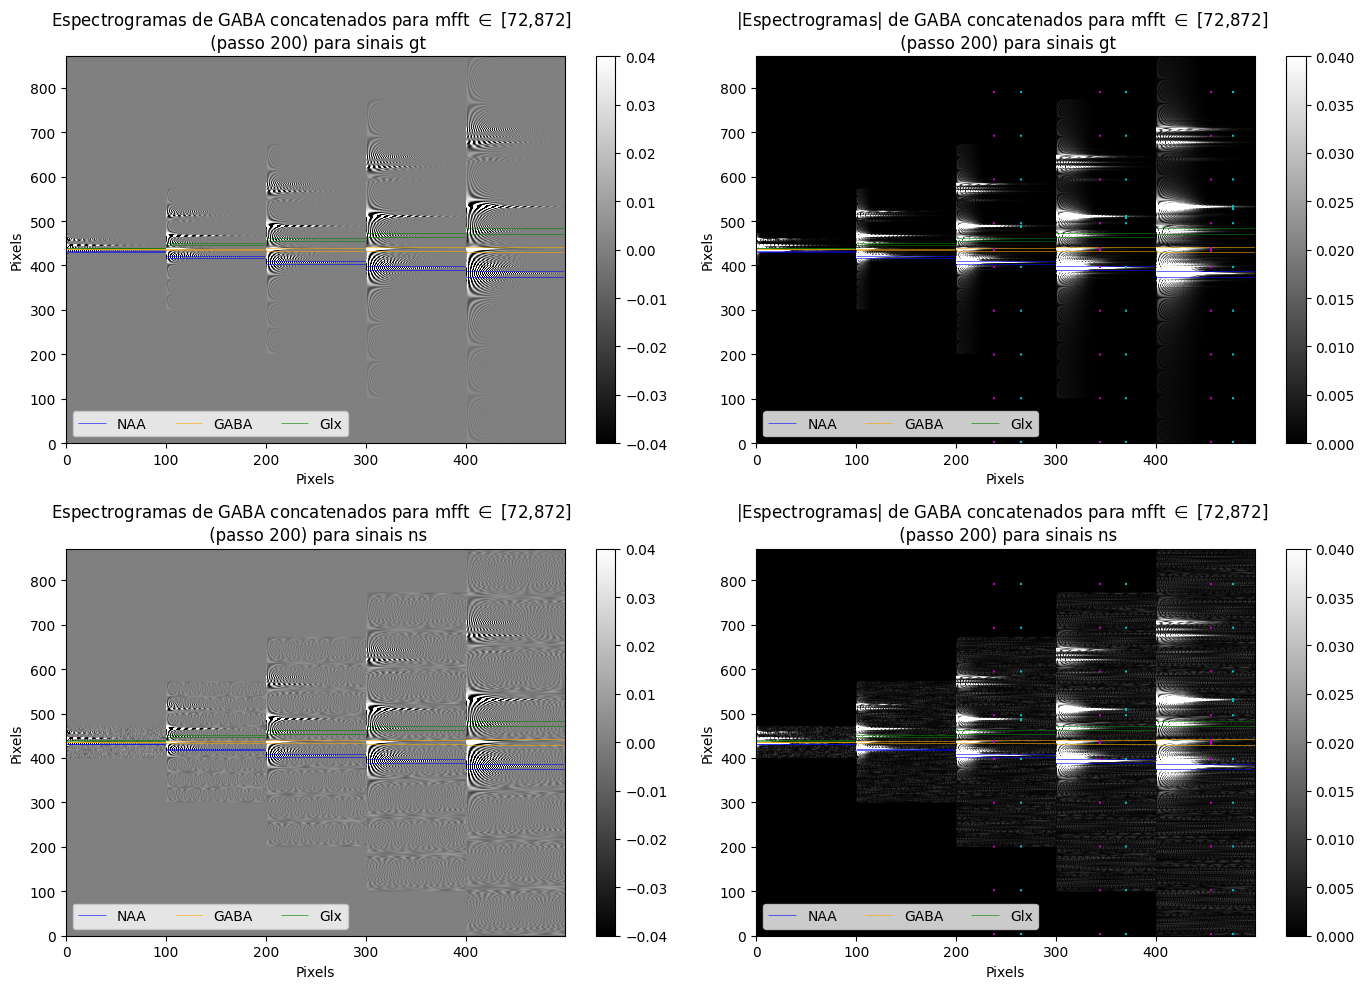

In [15]:
fig,ax = plt.subplots(2,2,figsize=(14,10))
im = ax[1,0].imshow(np.real(spgram_mfft_ns_concat), origin='lower',cmap='gray',aspect='auto',vmin=-0.04,vmax=0.04)
fig.colorbar(im, ax=ax[1,0])
im = ax[1,1].imshow(np.abs(np.real(spgram_mfft_ns_concat)), origin='lower',cmap='gray',aspect='auto',vmin=0,vmax=0.04)
fig.colorbar(im, ax=ax[1,1])
im = ax[0,0].imshow(np.real(spgram_mfft_gt_concat), origin='lower',cmap='gray',aspect='auto',vmin=-0.04,vmax=0.04)
fig.colorbar(im, ax=ax[0,0])
im = ax[0,1].imshow(np.abs(np.real(spgram_mfft_gt_concat)), origin='lower',cmap='gray',aspect='auto',vmin=0,vmax=0.04)
fig.colorbar(im, ax=ax[0,1])
count = 0
center = spgram_mfft_ns_concat.shape[0]/2
idx_aux = idx_time_0d4[0]
for i in range(2,len(mfft_),10):
    if i ==2:
        aux = spgram_mfft_ns['mfft_'+str(mfft_[i])][0].shape[1]
        for j in range(4):
            ax.flat[j].hlines(center-int(aux/2)+idx_freq_1d9ppm[i],count,count+idx_aux-1,color='b',linewidth=0.42,label='NAA')
            ax.flat[j].hlines(center-int(aux/2)+idx_freq_2d12ppm[i],count,count+idx_aux-1,color='b',linewidth=0.42)
            ax.flat[j].hlines(center-int(aux/2)+idx_freq_2d9ppm[i],count,count+idx_aux-1,color='orange',linewidth=0.42,label='GABA')
            ax.flat[j].hlines(center-int(aux/2)+idx_freq_3d12ppm[i],count,count+idx_aux-1,color='orange',linewidth=0.42)
            ax.flat[j].hlines(center-int(aux/2)+idx_freq_3d87ppm[i],count,count+idx_aux-1,color='g',linewidth=0.42,label='Glx')
            ax.flat[j].hlines(center-int(aux/2)+idx_freq_3d64ppm[i],count,count+idx_aux-1,color='g',linewidth=0.42)
    else:
        aux = spgram_mfft_ns['mfft_'+str(mfft_[i])][0].shape[1]
        for j in range(4):
            ax.flat[j].hlines(center-int(aux/2)+idx_freq_1d9ppm[i],count,count+idx_aux-1,color='b',linewidth=0.42)
            ax.flat[j].hlines(center-int(aux/2)+idx_freq_2d12ppm[i],count,count+idx_aux-1,color='b',linewidth=0.42)
            ax.flat[j].hlines(center-int(aux/2)+idx_freq_2d9ppm[i],count,count+idx_aux-1,color='orange',linewidth=0.42)
            ax.flat[j].hlines(center-int(aux/2)+idx_freq_3d12ppm[i],count,count+idx_aux-1,color='orange',linewidth=0.42)
            ax.flat[j].hlines(center-int(aux/2)+idx_freq_3d87ppm[i],count,count+idx_aux-1,color='g',linewidth=0.42)
            ax.flat[j].hlines(center-int(aux/2)+idx_freq_3d64ppm[i],count,count+idx_aux-1,color='g',linewidth=0.42)
            #ax[j].hlines(center-int(aux/2)+idx_freq_4d6ppm[i],count,count+idx_aux-1,color='m',linewidth=0.42)
            #ax[j].hlines(center-int(aux/2)+idx_freq_4d8ppm[i],count,count+idx_aux-1,color='m',linewidth=0.42)
    count = count+idx_aux
for j in range(4):
    ax.flat[j].legend(loc='lower left',ncols=3)
    ax.flat[j].set_xlabel('Pixels')
    ax.flat[j].set_ylabel('Pixels')

for j in range(2):
    aux = spgram_mfft_ns['mfft_'+str(mfft_[22])][0].shape[1]
    ax[j,1].vlines(238,center-int(aux/2)+idx_freq_2d9ppm[22],center-int(aux/2)+idx_freq_3d12ppm[22],color='m')
    aux = spgram_mfft_ns['mfft_'+str(mfft_[32])][0].shape[1]
    ax[j,1].vlines(344,center-int(aux/2)+idx_freq_2d9ppm[32],center-int(aux/2)+idx_freq_3d12ppm[32],color='m')
    aux = spgram_mfft_ns['mfft_'+str(mfft_[42])][0].shape[1]
    ax[j,1].vlines(455,center-int(aux/2)+idx_freq_2d9ppm[42],center-int(aux/2)+idx_freq_3d12ppm[42],color='m')
    
    aux = spgram_mfft_ns['mfft_'+str(mfft_[22])][0].shape[1]
    ax[j,1].vlines(265,center-int(aux/2)+idx_freq_4d6ppm[22],center-int(aux/2)+idx_freq_4d8ppm[22],color='c')
    aux = spgram_mfft_ns['mfft_'+str(mfft_[32])][0].shape[1]
    ax[j,1].vlines(370,center-int(aux/2)+idx_freq_4d6ppm[32],center-int(aux/2)+idx_freq_4d8ppm[32],color='c')
    aux = spgram_mfft_ns['mfft_'+str(mfft_[42])][0].shape[1]
    ax[j,1].vlines(477,center-int(aux/2)+idx_freq_4d6ppm[42],center-int(aux/2)+idx_freq_4d8ppm[42],color='c')
    
    ax[j,1].vlines(238,1,870,color='m',linestyle=(0, (1, 20)))
    ax[j,1].vlines(344,1,870,color='m',linestyle=(0, (1, 20)))
    ax[j,1].vlines(455,1,870,color='m',linestyle=(0, (1, 20)))
    ax[j,1].vlines(265,1,870,color='c',linestyle=(0, (1, 20)))
    ax[j,1].vlines(370,1,870,color='c',linestyle=(0, (1, 20)))
    ax[j,1].vlines(477,1,870,color='c',linestyle=(0, (1, 20)))

ax[1,0].set_title('Espectrogramas de GABA concatenados para mfft $\in$ [72,872]  \n (passo 200) para sinais ns')
ax[1,1].set_title('|Espectrogramas| de GABA concatenados para mfft $\in$ [72,872]  \n (passo 200) para sinais ns')
ax[0,0].set_title('Espectrogramas de GABA concatenados para mfft $\in$ [72,872]  \n (passo 200) para sinais gt')
ax[0,1].set_title('|Espectrogramas| de GABA concatenados para mfft $\in$ [72,872]  \n (passo 200) para sinais gt')
plt.tight_layout()
if test_not_save == False:
    plt.savefig('./relatorio_imagens/imagens_mfft/spgram_varying_mfft_abs_concatenated_image.png')

### 2.3 O aumento da mfft aumenta o comprimento dos picos?

Para responder essa questão baseando-se em métricas quantitativas e análise visual, gera-se espectrogramas extras considerando hop = 20. 

In [16]:
#MFFT FOR HOP 20 FOR BETTER VISUALIZATION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
mfft_ = np.arange(32,1024,20)
window_ = []
for i in range(mfft_.shape[0]):
    window_.append(hann(int(mfft_[i]),sym=True))
hop_aux = 20
norm_ = 'abs'
spgram_mfft_gt_aux = {}
spgram_mfft_ns_aux = {}
for i in range(mfft_.shape[0]):
    spgram_gt, freq_spect, ppm_spect, t_spect = utils.get_normalized_spectrogram(fids=gt_fids[:,:,1]-gt_fids[:,:,0],bandwidth=bandwidth,window=window_[i],mfft=int(mfft_[i]),hop=hop_aux,norm=norm_,correct_time=True,a=a,b=b)
    spgram_mfft_gt_aux['mfft_'+str(mfft_[i])] = [spgram_gt, freq_spect, ppm_spect, t_spect]
    spgram_ns, freq_spect, ppm_spect, t_spect = utils.get_normalized_spectrogram(fids=np.mean(corrupted_fids[:,:,1,:]-corrupted_fids[:,:,0,:],axis=2),bandwidth=bandwidth,window=window_[i],mfft=int(mfft_[i]),hop=hop_aux,norm=norm_,correct_time=True,a=a,b=b)
    spgram_mfft_ns_aux['mfft_'+str(mfft_[i])] = [spgram_ns, freq_spect, ppm_spect, t_spect]
list_of_t_spects_aux = []
list_of_ppm_spects_aux = []
for i in range(mfft_.shape[0]):
    list_of_t_spects_aux.append(spgram_mfft_gt_aux['mfft_'+str(mfft_[i])][-1])
    list_of_ppm_spects_aux.append(spgram_mfft_gt_aux['mfft_'+str(mfft_[i])][2])
idx_time_0d4_aux = utils.give_idx_time_point_for_different_time_arrays(list_time_arrays=list_of_t_spects_aux,time_point=0.4)
idx_freq_NAA_aux = utils.give_idx_ppm_point_for_different_ppm_arrays(list_ppm_arrays=list_of_ppm_spects_aux,ppm_point=2.02)
idx_freq_GABA_aux = utils.give_idx_ppm_point_for_different_ppm_arrays(list_ppm_arrays=list_of_ppm_spects_aux,ppm_point=3.00)
idx_freq_Glx_aux = utils.give_idx_ppm_point_for_different_ppm_arrays(list_ppm_arrays=list_of_ppm_spects_aux,ppm_point=3.75)
idx_freq_m2ppm_aux = utils.give_idx_ppm_point_for_different_ppm_arrays(list_ppm_arrays=list_of_ppm_spects_aux,ppm_point=-2)
aux_concat = (np.arange(2,len(mfft_),10)).tolist()
aux_concat_NAA_idx = []
aux_concat_Glx_idx = []
aux_concat_m2ppm_idx = []
plot_concat = []
for idx in aux_concat:
    plot_concat.append(mfft_[idx])
    aux_concat_NAA_idx.append(idx_freq_NAA_aux[idx])
    aux_concat_Glx_idx.append(idx_freq_Glx_aux[idx])
    aux_concat_m2ppm_idx.append(idx_freq_m2ppm_aux[idx])
    
spgram_mfft_gt_concat_aux = funcstud.concatenate_different_mfft(list_mfft_idx=plot_concat,spgram_dict=spgram_mfft_gt_aux,time_idx=idx_time_0d4_aux[0],fid_idx_plot=0)
spgram_mfft_gt_concat_NAA_aux = funcstud.concatenate_different_mfft(list_mfft_idx=plot_concat,spgram_dict=spgram_mfft_gt_aux,time_idx=idx_time_0d4_aux[0],fid_idx_plot=0,centered_ppm_last=idx_freq_NAA_aux[aux_concat[-1]],list_idx_of_centered=aux_concat_NAA_idx)
spgram_mfft_gt_concat_Glx_aux = funcstud.concatenate_different_mfft(list_mfft_idx=plot_concat,spgram_dict=spgram_mfft_gt_aux,time_idx=idx_time_0d4_aux[0],fid_idx_plot=0,centered_ppm_last=idx_freq_Glx_aux[aux_concat[-1]],list_idx_of_centered=aux_concat_Glx_idx)
spgram_mfft_ns_concat_aux = funcstud.concatenate_different_mfft(list_mfft_idx=plot_concat,spgram_dict=spgram_mfft_ns_aux,time_idx=idx_time_0d4_aux[0],fid_idx_plot=0)
spgram_mfft_ns_concat_m2ppm_aux = funcstud.concatenate_different_mfft(list_mfft_idx=plot_concat,spgram_dict=spgram_mfft_ns_aux,time_idx=idx_time_0d4_aux[0],fid_idx_plot=0,centered_ppm_last=idx_freq_m2ppm_aux[aux_concat[-1]],list_idx_of_centered=aux_concat_m2ppm_idx)

#### 2.3.1 Análise visual

Observando com zoom em diferentes regiões:
- GABA se torna mais alongado conforme mfft aumenta para hop = 8 e hop = 20.
- Para NAA e Glx é mais difícil julgar para hop = 8, pois as faixas são muito estreitas --> motiva a observação com hop maior.
- Com hop igual a 20, nota-se um alongamento dos picos NAA e Glx. Eles ocupam uma área maior na imagem, tanto pelo aumento das linhas (já observado), quanto por um aumento na extensão dos picos (na direção das colunas).

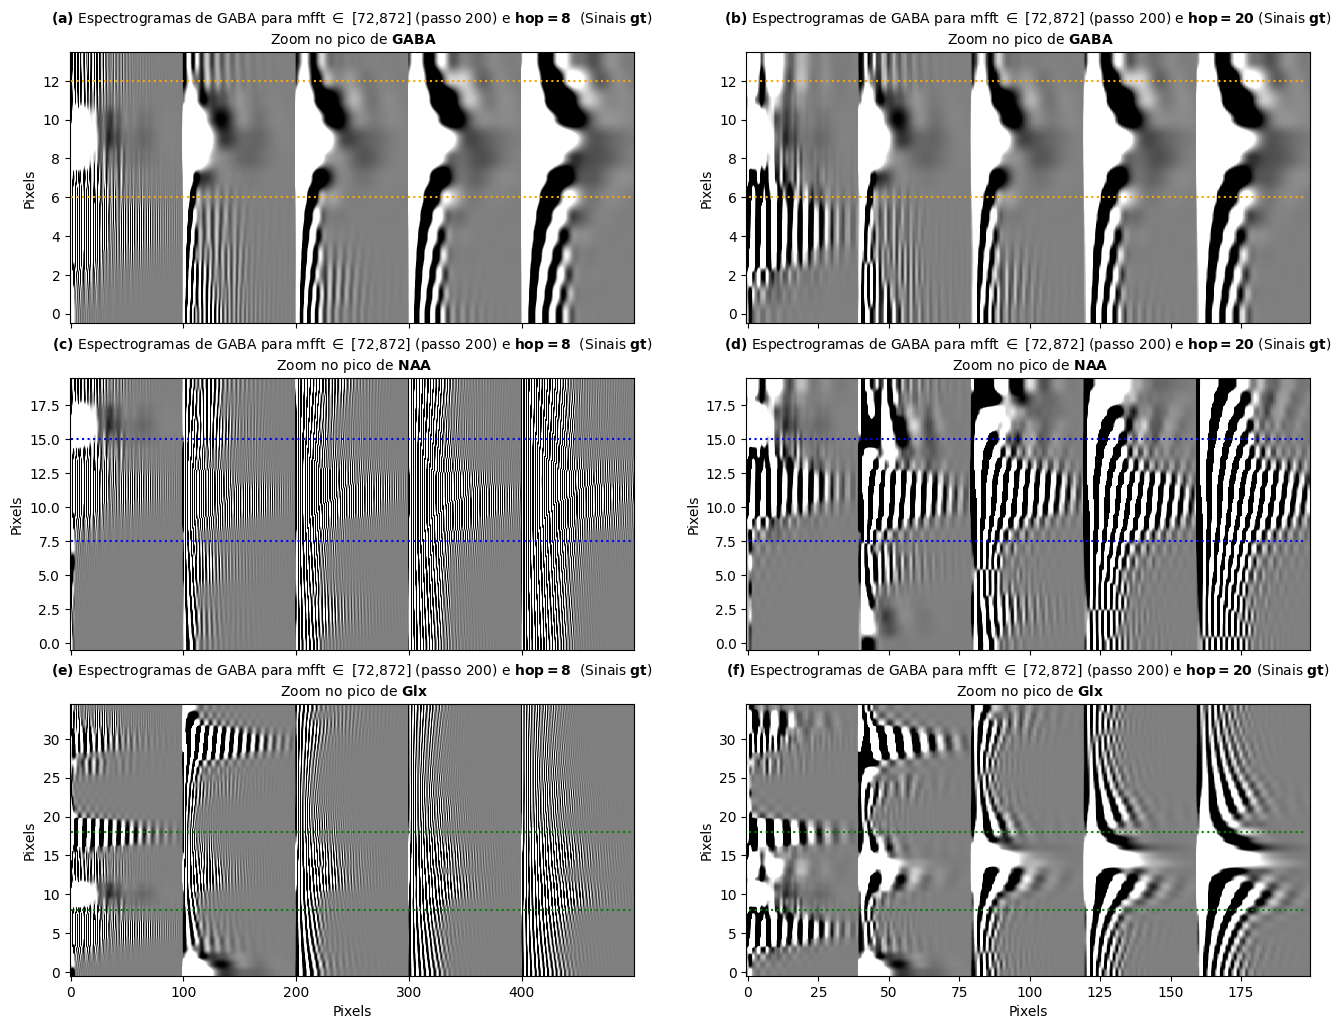

In [17]:
fig,ax = plt.subplots(3,2,figsize=(16,12),sharex='col')
center = spgram_mfft_gt_concat.shape[0]/2
aux = spgram_mfft_gt['mfft_'+str(mfft_[2])][0].shape[1]
ax.flat[0].imshow(np.real(spgram_mfft_gt_concat[int(center)-int(aux/2)+idx_freq_1ppm[2]:int(center)-int(aux/2)+idx_freq_4ppm[2],:]), origin='lower', 
             aspect='auto',cmap='gray',vmin=-0.01,vmax=0.01)
ax.flat[2].imshow(np.real(spgram_mfft_gt_concat_NAA[370:390,:]), origin='lower', 
             aspect='auto',cmap='gray',vmin=-0.01,vmax=0.01)
ax.flat[4].imshow(np.real(spgram_mfft_gt_concat_Glx[465:500,:]), origin='lower', 
             aspect='auto',cmap='gray',vmin=-0.01,vmax=0.01)
center = spgram_mfft_gt_concat_aux.shape[0]/2
aux = spgram_mfft_gt_aux['mfft_'+str(mfft_[2])][0].shape[1]
ax.flat[1].imshow(np.real(spgram_mfft_gt_concat_aux[int(center)-int(aux/2)+idx_freq_1ppm[2]:int(center)-int(aux/2)+idx_freq_4ppm[2],:]), origin='lower', 
             aspect='auto',cmap='gray',vmin=-0.01,vmax=0.01)
ax.flat[3].imshow(np.real(spgram_mfft_gt_concat_NAA_aux[370:390,:]), origin='lower', 
             aspect='auto',cmap='gray',vmin=-0.01,vmax=0.01)
ax.flat[5].imshow(np.real(spgram_mfft_gt_concat_Glx_aux[465:500,:]), origin='lower', 
             aspect='auto',cmap='gray',vmin=-0.01,vmax=0.01)

ax.flat[0].hlines(12,0.5,498,color='orange',linestyle='dotted')
ax.flat[0].hlines(6,0.5,498,color='orange',linestyle='dotted')
ax.flat[1].hlines(12,0.5,198,color='orange',linestyle='dotted')
ax.flat[1].hlines(6,0.5,198,color='orange',linestyle='dotted')
ax.flat[2].hlines(15,0.5,498,color='blue',linestyle='dotted')
ax.flat[2].hlines(7.5,0.5,498,color='blue',linestyle='dotted')
ax.flat[3].hlines(15,0.5,198,color='blue',linestyle='dotted')
ax.flat[3].hlines(7.5,0.5,198,color='blue',linestyle='dotted')
ax.flat[4].hlines(18,0.5,498,color='green',linestyle='dotted')
ax.flat[4].hlines(8,0.5,498,color='green',linestyle='dotted')
ax.flat[5].hlines(18,0.5,198,color='green',linestyle='dotted')
ax.flat[5].hlines(8,0.5,198,color='green',linestyle='dotted')

for i in range(6):
    ax.flat[i].set_ylabel('Pixels')
ax.flat[0].set_title('$\mathbf{(a)}$ Espectrogramas de GABA para mfft $\in $ [72,872] (passo 200) e $\mathbf{hop=8}$  (Sinais $\mathbf{gt}$)\n Zoom no pico de $\mathbf{GABA}$',fontsize=10)
ax.flat[1].set_title('$\mathbf{(b)}$ Espectrogramas de GABA para mfft $\in $ [72,872] (passo 200) e $\mathbf{hop=20}$ (Sinais $\mathbf{gt}$) \n Zoom no pico de $\mathbf{GABA}$',fontsize=10)
ax.flat[2].set_title('$\mathbf{(c)}$ Espectrogramas de GABA para mfft $\in $ [72,872] (passo 200) e $\mathbf{hop=8}$  (Sinais $\mathbf{gt}$)\n Zoom no pico de $\mathbf{NAA}$',fontsize=10)
ax.flat[3].set_title('$\mathbf{(d)}$ Espectrogramas de GABA para mfft $\in $ [72,872] (passo 200) e $\mathbf{hop=20}$ (Sinais $\mathbf{gt}$) \n Zoom no pico de $\mathbf{NAA}$',fontsize=10)
ax.flat[4].set_title('$\mathbf{(e)}$ Espectrogramas de GABA para mfft $\in $ [72,872] (passo 200) e $\mathbf{hop=8}$  (Sinais $\mathbf{gt}$)\n Zoom no pico de $\mathbf{Glx}$',fontsize=10)
ax.flat[5].set_title('$\mathbf{(f)}$ Espectrogramas de GABA para mfft $\in $ [72,872] (passo 200) e $\mathbf{hop=20}$ (Sinais $\mathbf{gt}$) \n Zoom no pico de $\mathbf{Glx}$',fontsize=10)

ax.flat[4].set_xlabel('Pixels')
ax.flat[5].set_xlabel('Pixels')
if test_not_save == False:
    plt.savefig('./relatorio_imagens/imagens_mfft/spgram_varying_mfft_concatenated_images_zoom_in_peaks.png')

#### 2.3.2 Análise quantitativa

Pelo comprimento medido dos picos, fica evidente o aumento no comprimento do GABA. Também nota-se um ligeiro aumento do Glx, conforme esperado pela análise visual. No entanto, para o pico de NAA, os valores de comprimento oscilam em torno de um valor médio, e não fica claro um aumento na medição do comprimento. Supõe-se uma dificuldade na medição do comprimento do NAA para o valor de hop considerado (hop = 8), possivelmente derivado do método de segmentação proposto para o pico. Os picos segmentados e as máscras de segmentação utilizadas para o cálculo do comprimento são visiveis na imagem abaixo para alguns valores de mfft.

Observação: A medição do comprimento dos picos considera espectrogramas obtidos com hop = 8 APENAS!

In [18]:
list_projections_real_gt = []
list_of_ppm_spects = []
idx_freq_NAA_aux = []
idx_freq_GABA_aux = []
idx_freq_Glx_aux = []
idx_fwhm_real_gt = {}
for i in range(len(mfft_)):
    list_projections_real_gt.append(np.sum(np.real(spgram_mfft_gt['mfft_'+str(mfft_[i])][0]), axis = 2))
    list_of_ppm_spects.append(spgram_mfft_gt['mfft_'+str(mfft_[i])][2])
    idx_fwhm_real_gt['mfft_'+str(mfft_[i])] = {}
    
aux, aux_idx_NAA_real = utils.get_fwhm_in_ppm_for_different_signals(list_signals=list_projections_real_gt,list_peak_idx=idx_freq_NAA,list_ppm=list_of_ppm_spects,peak_ppm_plus=2.50,peak_ppm_minus=1.50,preference='negative')
aux, aux_idx_GABA_real = utils.get_fwhm_in_ppm_for_different_signals(list_signals=list_projections_real_gt,list_peak_idx=idx_freq_GABA,list_ppm=list_of_ppm_spects,peak_ppm_plus=3.50,peak_ppm_minus=2.50,preference='positive')
aux, aux_idx_Glx_real = utils.get_fwhm_in_ppm_for_different_signals(list_signals=list_projections_real_gt,list_peak_idx=idx_freq_Glx,list_ppm=list_of_ppm_spects,peak_ppm_plus=4.00,peak_ppm_minus=3.50,preference='positive')

for i in range(len(mfft_)):
    idx_fwhm_real_gt['mfft_'+str(mfft_[i])]['NAA'] = aux_idx_NAA_real[i]
    idx_fwhm_real_gt['mfft_'+str(mfft_[i])]['GABA'] = aux_idx_GABA_real[i]
    idx_fwhm_real_gt['mfft_'+str(mfft_[i])]['Glx'] = aux_idx_Glx_real[i]
segm_dict = funcstud.segment_relevant_peaks_dict(spgram_dict=spgram_mfft_gt,idx_list_1ppm=idx_freq_1ppm,idx_list_4ppm=idx_freq_4ppm,idx_list_GABA=idx_freq_GABA,idx_list_NAA=idx_freq_NAA,idx_list_Glx=idx_freq_Glx,idx_time_list_0d4=idx_time_0d4,idx_peaks_regions_limits_dict=idx_fwhm_real_gt)

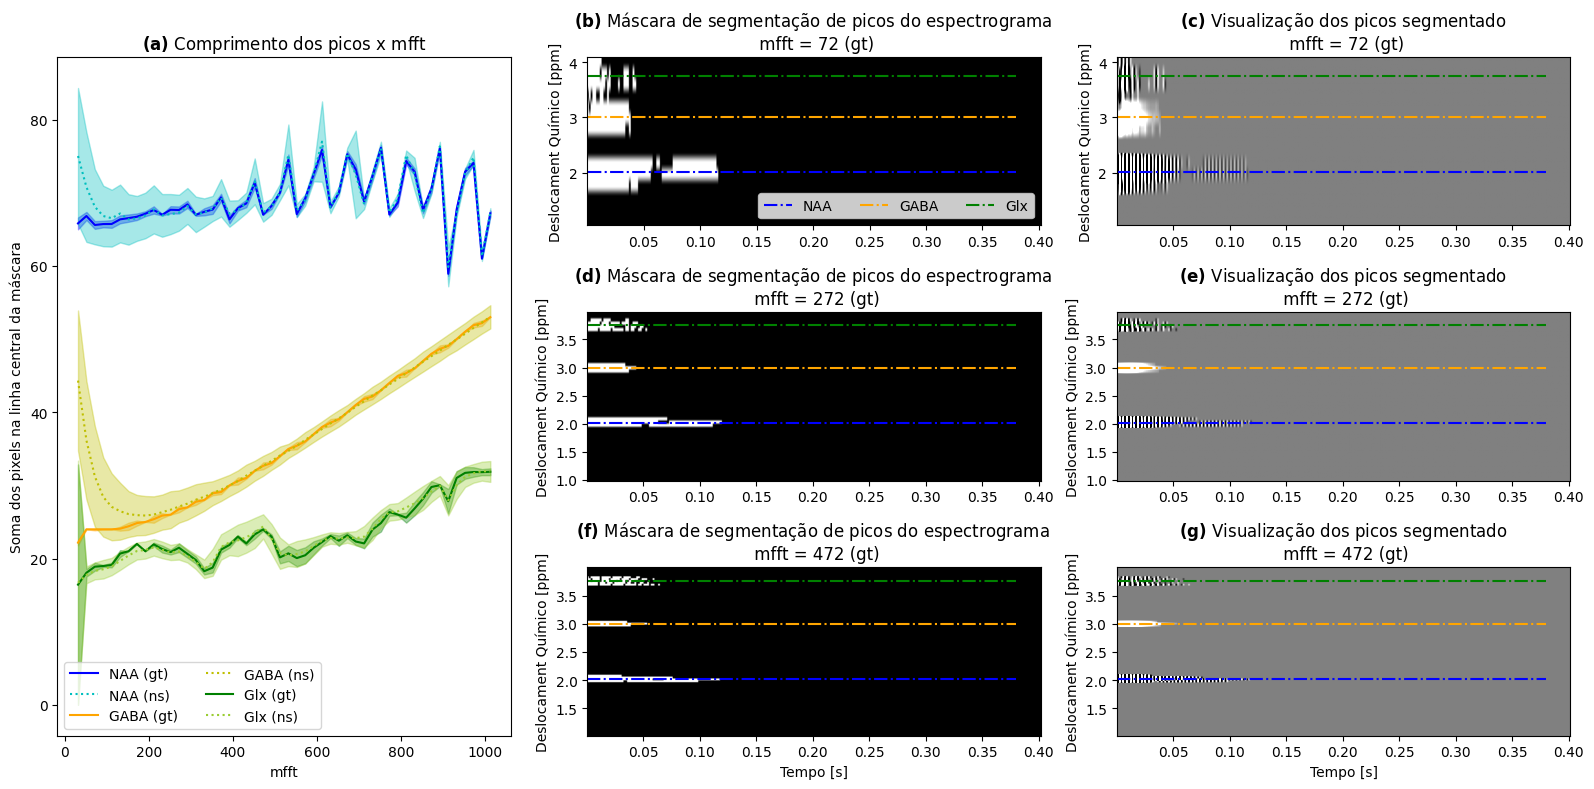

In [19]:
from matplotlib.gridspec import GridSpec
# Create figure and GridSpec
fig = plt.figure(figsize=(16, 8))
gs = gridspec.GridSpec(3, 3, height_ratios=[1, 1, 1])
ax1 = fig.add_subplot(gs[0:3, 0])  
ax2 = fig.add_subplot(gs[0, 1]) 
ax3 = fig.add_subplot(gs[0, 2])  
ax4 = fig.add_subplot(gs[1, 1]) 
ax5 = fig.add_subplot(gs[1, 2])    
ax6 = fig.add_subplot(gs[2, 1]) 
ax7 = fig.add_subplot(gs[2, 2])


ax1.plot(mfft_,gt_metrics['sum_segment']['NAA']['mean'],label='NAA (gt)',color='b')
ax1.fill_between(mfft_, np.array(gt_metrics['sum_segment']['NAA']['mean']) - np.array(gt_metrics['sum_segment']['NAA']['std']), 
                        np.array(gt_metrics['sum_segment']['NAA']['mean']) + np.array(gt_metrics['sum_segment']['NAA']['std']), alpha=0.35, color = 'b')
ax1.plot(mfft_,ns_metrics['sum_segment']['NAA']['mean'],label='NAA (ns)',color='c',linestyle='dotted')
ax1.fill_between(mfft_, np.array(ns_metrics['sum_segment']['NAA']['mean']) - np.array(ns_metrics['sum_segment']['NAA']['std']), 
                        np.array(ns_metrics['sum_segment']['NAA']['mean']) + np.array(ns_metrics['sum_segment']['NAA']['std']), alpha=0.35, color = 'c')
ax1.plot(mfft_,gt_metrics['sum_segment']['GABA']['mean'],label='GABA (gt)',color='orange')
ax1.fill_between(mfft_, np.array(gt_metrics['sum_segment']['GABA']['mean']) - np.array(gt_metrics['sum_segment']['GABA']['std']), 
                        np.array(gt_metrics['sum_segment']['GABA']['mean']) + np.array(gt_metrics['sum_segment']['GABA']['std']), alpha=0.35, color = 'orange')
ax1.plot(mfft_,ns_metrics['sum_segment']['GABA']['mean'],label='GABA (ns)',color='y',linestyle='dotted')
ax1.fill_between(mfft_, np.array(ns_metrics['sum_segment']['GABA']['mean']) - np.array(ns_metrics['sum_segment']['GABA']['std']), 
                        np.array(ns_metrics['sum_segment']['GABA']['mean']) + np.array(ns_metrics['sum_segment']['GABA']['std']), alpha=0.35, color = 'y')
ax1.plot(mfft_,gt_metrics['sum_segment']['Glx']['mean'],label='Glx (gt)',color='g')
ax1.fill_between(mfft_, np.array(gt_metrics['sum_segment']['Glx']['mean']) - np.array(gt_metrics['sum_segment']['Glx']['std']), 
                        np.array(gt_metrics['sum_segment']['Glx']['mean']) + np.array(gt_metrics['sum_segment']['Glx']['std']), alpha=0.35, color = 'g')
ax1.plot(mfft_,ns_metrics['sum_segment']['Glx']['mean'],label='Glx (ns)',color='yellowgreen',linestyle='dotted')
ax1.fill_between(mfft_, np.array(ns_metrics['sum_segment']['Glx']['mean']) - np.array(ns_metrics['sum_segment']['Glx']['std']), 
                        np.array(ns_metrics['sum_segment']['Glx']['mean']) + np.array(ns_metrics['sum_segment']['Glx']['std']), alpha=0.35, color = 'yellowgreen')
ax1.set_xlabel('mfft')
ax1.set_ylabel('Soma dos pixels na linha central da máscara')
ax1.set_title('$\mathbf{(a)}$ Comprimento dos picos x mfft')
ax1.legend(loc='lower left',ncols=2,fontsize=10)

idx_plot_mfft = [2,12,22]
idx_ax = [ax2,ax3,ax4,ax5,ax6,ax7]
for i in range(3):
    idx_ax[2*i].imshow(segm_dict['mfft_'+str(mfft_[idx_plot_mfft[i]])][0,:,:],cmap='gray',aspect='auto',origin='lower', vmin=0, vmax=1, extent=(spgram_mfft_gt['mfft_'+str(mfft_[idx_plot_mfft[i]])][-1][0],
                                                                                                                                spgram_mfft_gt['mfft_'+str(mfft_[idx_plot_mfft[i]])][-1][idx_time_0d4[idx_plot_mfft[i]]],
                                                                                                                                np.flip(spgram_mfft_gt['mfft_'+str(mfft_[idx_plot_mfft[i]])][2])[idx_freq_1ppm[idx_plot_mfft[i]]],
                                                                                                                                np.flip(spgram_mfft_gt['mfft_'+str(mfft_[idx_plot_mfft[i]])][2])[idx_freq_4ppm[idx_plot_mfft[i]]]))
    idx_ax[2*i+1].imshow(segm_dict['mfft_'+str(mfft_[idx_plot_mfft[i]])][0,:,:]*np.real(spgram_mfft_gt['mfft_'+str(mfft_[idx_plot_mfft[i]])][0][0,idx_freq_1ppm[idx_plot_mfft[i]]:idx_freq_4ppm[idx_plot_mfft[i]]+1,:]),cmap='gray',aspect='auto',origin='lower',
                         vmin=-0.04,vmax=0.04,extent=(spgram_mfft_gt['mfft_'+str(mfft_[idx_plot_mfft[i]])][-1][0],
                                                                                                                                spgram_mfft_gt['mfft_'+str(mfft_[idx_plot_mfft[i]])][-1][idx_time_0d4[idx_plot_mfft[i]]],
                                                                                                                                np.flip(spgram_mfft_gt['mfft_'+str(mfft_[idx_plot_mfft[i]])][2])[idx_freq_1ppm[idx_plot_mfft[i]]],
                                                                                                                                np.flip(spgram_mfft_gt['mfft_'+str(mfft_[idx_plot_mfft[i]])][2])[idx_freq_4ppm[idx_plot_mfft[i]]]))
    for j in range(2):
        if i ==0 and j ==0:
            idx_ax[2*i+j].hlines(2.02,0.0005,0.38,color='b',linestyle='dashdot',label='NAA')
            idx_ax[2*i+j].hlines(3,0.0005,0.38,color='orange',linestyle='dashdot',label='GABA')
            idx_ax[2*i+j].hlines(3.75,0.0005,0.38,color='g',linestyle='dashdot',label='Glx')
            idx_ax[2*i+j].legend(loc='lower right',ncols=3)
        else:
            idx_ax[2*i+j].hlines(2.02,0.0005,0.38,color='b',linestyle='dashdot')
            idx_ax[2*i+j].hlines(3,0.0005,0.38,color='orange',linestyle='dashdot')
            idx_ax[2*i+j].hlines(3.75,0.0005,0.38,color='g',linestyle='dashdot')

for i in range(6):
    idx_ax[i].set_ylabel('Deslocament Químico [ppm]')
ax6.set_xlabel('Tempo [s]')
ax7.set_xlabel('Tempo [s]')

ax2.set_title('$\mathbf{(b)}$ Máscara de segmentação de picos do espectrograma \n mfft = 72 (gt)')
ax3.set_title('$\mathbf{(c)}$ Visualização dos picos segmentado \n mfft = 72 (gt)')
ax4.set_title('$\mathbf{(d)}$ Máscara de segmentação de picos do espectrograma \n mfft = 272 (gt)')
ax5.set_title('$\mathbf{(e)}$ Visualização dos picos segmentado \n mfft = 272 (gt)')
ax6.set_title('$\mathbf{(f)}$ Máscara de segmentação de picos do espectrograma \n mfft = 472 (gt)')
ax7.set_title('$\mathbf{(g)}$ Visualização dos picos segmentado \n mfft = 472 (gt)')
plt.tight_layout()
if test_not_save == False:
    plt.savefig('./relatorio_imagens/imagens_mfft/spgram_varying_mfft_sum_segment.png')

### 2.4 Quantificação do afinamento dos picos com mfft

Cálculo da largura dos picos pela projeção no eixo da frequência:

In [20]:
plot_id = np.arange(3,len(mfft_),10).tolist()
list_projections_abs_gt = []
list_projections_real_gt = []
list_projections_abs_ns = []
list_projections_real_ns = []
idx_fwhm_gt = {}
idx_fwhm_real_gt = {}
idx_fwhm_ns = {}
idx_fwhm_real_ns = {}
list_of_ppm_spects = []
idx_freq_NAA_aux = []
idx_freq_GABA_aux = []
idx_freq_Glx_aux = []
for i in range(len(plot_id)):
    list_projections_abs_gt.append(np.sum(np.abs(np.real(spgram_mfft_gt['mfft_'+str(mfft_[plot_id[i]])][0])), axis = 2))
    list_projections_real_gt.append(np.sum(np.real(spgram_mfft_gt['mfft_'+str(mfft_[plot_id[i]])][0]), axis = 2))
    list_projections_abs_ns.append(np.sum(np.abs(np.real(spgram_mfft_ns['mfft_'+str(mfft_[plot_id[i]])][0])), axis = 2))
    list_projections_real_ns.append(np.sum(np.real(spgram_mfft_ns['mfft_'+str(mfft_[plot_id[i]])][0]), axis = 2))
    idx_fwhm_gt['mfft_'+str(mfft_[plot_id[i]])] = {}
    idx_fwhm_real_gt['mfft_'+str(mfft_[plot_id[i]])] = {}
    idx_fwhm_ns['mfft_'+str(mfft_[plot_id[i]])] = {}
    idx_fwhm_real_ns['mfft_'+str(mfft_[plot_id[i]])] = {}
    list_of_ppm_spects.append(spgram_mfft_gt['mfft_'+str(mfft_[plot_id[i]])][2])
    idx_freq_NAA_aux.append(idx_freq_NAA[plot_id[i]])
    idx_freq_GABA_aux.append(idx_freq_GABA[plot_id[i]])
    idx_freq_Glx_aux.append(idx_freq_Glx[plot_id[i]])

print('starting gt data')
aux, aux_idx_NAA_abs = utils.get_fwhm_in_ppm_for_different_signals(list_signals=list_projections_abs_gt,list_peak_idx=idx_freq_NAA_aux,list_ppm=list_of_ppm_spects,peak_ppm_plus=2.50,peak_ppm_minus=1.50,preference='positive')
aux, aux_idx_GABA_abs = utils.get_fwhm_in_ppm_for_different_signals(list_signals=list_projections_abs_gt,list_peak_idx=idx_freq_GABA_aux,list_ppm=list_of_ppm_spects,peak_ppm_plus=3.50,peak_ppm_minus=2.50,preference='positive')
aux, aux_idx_Glx_abs = utils.get_fwhm_in_ppm_for_different_signals(list_signals=list_projections_abs_gt,list_peak_idx=idx_freq_Glx_aux,list_ppm=list_of_ppm_spects,peak_ppm_plus=4.00,peak_ppm_minus=3.50,preference='positive')

aux, aux_idx_NAA_real = utils.get_fwhm_in_ppm_for_different_signals(list_signals=list_projections_real_gt,list_peak_idx=idx_freq_NAA_aux,list_ppm=list_of_ppm_spects,peak_ppm_plus=2.50,peak_ppm_minus=1.50,preference='negative')
aux, aux_idx_GABA_real = utils.get_fwhm_in_ppm_for_different_signals(list_signals=list_projections_real_gt,list_peak_idx=idx_freq_GABA_aux,list_ppm=list_of_ppm_spects,peak_ppm_plus=3.50,peak_ppm_minus=2.50,preference='positive')
aux, aux_idx_Glx_real = utils.get_fwhm_in_ppm_for_different_signals(list_signals=list_projections_real_gt,list_peak_idx=idx_freq_Glx_aux,list_ppm=list_of_ppm_spects,peak_ppm_plus=4.00,peak_ppm_minus=3.50,preference='positive')

print('adjusting for gt data')
for i in range(len(plot_id)):
    idx_fwhm_gt['mfft_'+str(mfft_[plot_id[i]])]['NAA'] = aux_idx_NAA_abs[i]
    idx_fwhm_gt['mfft_'+str(mfft_[plot_id[i]])]['GABA'] = aux_idx_GABA_abs[i]
    idx_fwhm_gt['mfft_'+str(mfft_[plot_id[i]])]['Glx'] = aux_idx_Glx_abs[i]
    idx_fwhm_real_gt['mfft_'+str(mfft_[plot_id[i]])]['NAA'] = aux_idx_NAA_real[i]
    idx_fwhm_real_gt['mfft_'+str(mfft_[plot_id[i]])]['GABA'] = aux_idx_GABA_real[i]
    idx_fwhm_real_gt['mfft_'+str(mfft_[plot_id[i]])]['Glx'] = aux_idx_Glx_real[i]

print('starting ns data')
aux, aux_idx_NAA_abs = utils.get_fwhm_in_ppm_for_different_signals(list_signals=list_projections_abs_ns,list_peak_idx=idx_freq_NAA_aux,list_ppm=list_of_ppm_spects,peak_ppm_plus=2.50,peak_ppm_minus=1.50,preference='positive')
aux, aux_idx_GABA_abs = utils.get_fwhm_in_ppm_for_different_signals(list_signals=list_projections_abs_ns,list_peak_idx=idx_freq_GABA_aux,list_ppm=list_of_ppm_spects,peak_ppm_plus=3.50,peak_ppm_minus=2.50,preference='positive')
aux, aux_idx_Glx_abs = utils.get_fwhm_in_ppm_for_different_signals(list_signals=list_projections_abs_ns,list_peak_idx=idx_freq_Glx_aux,list_ppm=list_of_ppm_spects,peak_ppm_plus=4.00,peak_ppm_minus=3.50,preference='positive')

aux, aux_idx_NAA_real = utils.get_fwhm_in_ppm_for_different_signals(list_signals=list_projections_real_ns,list_peak_idx=idx_freq_NAA_aux,list_ppm=list_of_ppm_spects,peak_ppm_plus=2.50,peak_ppm_minus=1.50,preference='negative')
aux, aux_idx_GABA_real = utils.get_fwhm_in_ppm_for_different_signals(list_signals=list_projections_real_ns,list_peak_idx=idx_freq_GABA_aux,list_ppm=list_of_ppm_spects,peak_ppm_plus=3.50,peak_ppm_minus=2.50,preference='positive')
aux, aux_idx_Glx_real = utils.get_fwhm_in_ppm_for_different_signals(list_signals=list_projections_real_ns,list_peak_idx=idx_freq_Glx_aux,list_ppm=list_of_ppm_spects,peak_ppm_plus=4.00,peak_ppm_minus=3.50,preference='positive')

print('adjusting for ns data')
for i in range(len(plot_id)):
    idx_fwhm_ns['mfft_'+str(mfft_[plot_id[i]])]['NAA'] = aux_idx_NAA_abs[i]
    idx_fwhm_ns['mfft_'+str(mfft_[plot_id[i]])]['GABA'] = aux_idx_GABA_abs[i]
    idx_fwhm_ns['mfft_'+str(mfft_[plot_id[i]])]['Glx'] = aux_idx_Glx_abs[i]
    idx_fwhm_real_ns['mfft_'+str(mfft_[plot_id[i]])]['NAA'] = aux_idx_NAA_real[i]
    idx_fwhm_real_ns['mfft_'+str(mfft_[plot_id[i]])]['GABA'] = aux_idx_GABA_real[i]
    idx_fwhm_real_ns['mfft_'+str(mfft_[plot_id[i]])]['Glx'] = aux_idx_Glx_real[i]

starting gt data
adjusting for gt data
starting ns data
adjusting for ns data


A questão da mudança frequencial pode ser estudada a partir da FWHM da projeção do espectrograma no eixo das frequências, a qual deveria, de certo modo, corresponder ao espectro do sinal. Tal projeção pode ser feita diretamente com a parte real do espectrograma, a qual corresponder ao espectro de GABA típico, que também considera apenas a parte real da FT, ou também pode ser feita considerando o valor absoluto da parte real. O interesse de utilizar a projeção do valor absoluto é que a mesma para de depender do padrão de listras da imagem. Como o hop altera esse padrão, ao considerar o valor absoluto tem-se a certeza de que os picos do espectrograma serão representados na projeção, pois na projeção simples, se a quantidade de listras pretas e brancas for igual para um determinado pico, sua projeção no eixo da frequência levaria a supressão do pico (assumindo simetria entre a intensidade dos valores positivos e negativos).

O que se conclui de Proj(|Espectrograma|):
- Segundo a métrica FWHM, para todos os picos, há um afinamento com o aumento de mfft, que parece se estabilizar para mfft $\approx$ 600.
- Isso se observa também pela visualização das projeções para sinais gt e ns. Para NAA e GABA, a visualização do afinamento é evidente e auxiliada pelas posições médias das meia-alturas. Nota-se, inclusive, que para os dois valores mais altos de mfft, a largura a meia-altura é igual, o que concorda com a medição da FWHM que se estabiliza para mfft maior que 600.
- No entanto, para o pico Glx, a visualização do afinamento e a visualização das posições médias de meia-altura não é tão evidente para sinais ns, onde as posições das meia-alturas não necessariamente condizem com as projeções médias (ex: mfft 892, meias-alturas deslocadas com relação a projeção média). Atribui-se esse resultado a influência do ruído, no pico, o qual não possui uma ampla amplitude. Isso se manifesta na FWHM pelo maior desvio padrão da métrica.
- Porém, ainda com relação ao Glx, no caso de sinais gt, para todo mfft, o pico mais alto é o próximo de 3.7 ppm, e a métrica FWHM se torna mais confiável do que no estudo do hop, pois a meia-altura é sempre medida com relação a esse pico.

O que se conclui de Proj(Espectrograma):
- Para todos os picos, há um afinamento com o aumento de mfft, que parece se estabilizar para mfft > 600. 
- O desvio-padrão de FWHM no caso dessa projeção é bem inferior a anterior, e a métrica demora mais a estabilizar (mais perto de mfft $\approx$ 700). Nota-se que para Proj(Espectrograma) a medição de FWHM x mfft é mais "lisa" que a medição feita em Proj(|Espectrograma|).
- Pela visualização das projeções médias e das posições médias da meia-altura também verifica-se o afinamento.

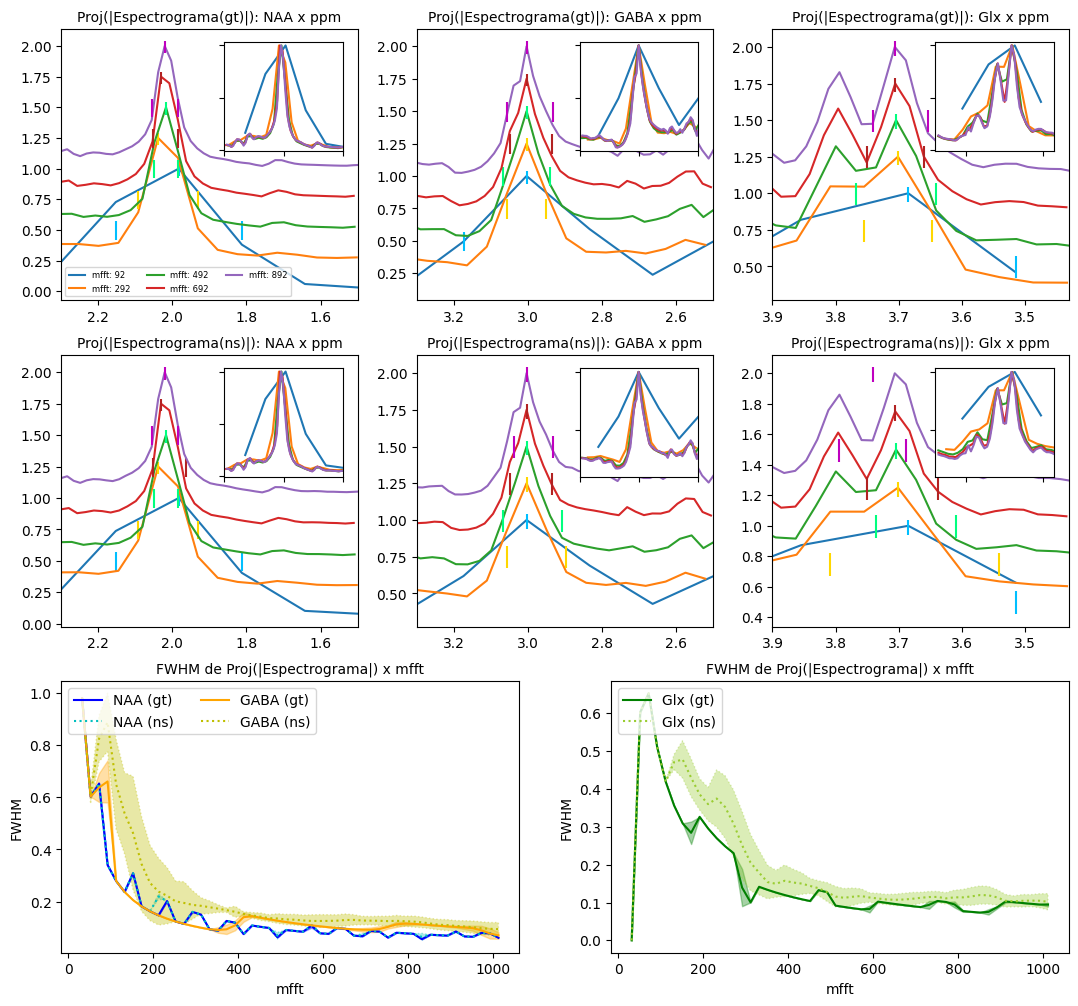

In [23]:
fig = plt.figure(figsize=(13, 12)) 

ax1 = plt.subplot2grid((3, 3), (0, 0))  
ax2 = plt.subplot2grid((3, 3), (0, 1))  
ax3 = plt.subplot2grid((3, 3), (0, 2)) 
ax6 = plt.subplot2grid((3, 3), (1, 0))  
ax7 = plt.subplot2grid((3, 3), (1, 1))  
ax8 = plt.subplot2grid((3, 3), (1, 2)) 

ax4 = plt.subplot2grid((3, 2), (2, 0)) 
ax5 = plt.subplot2grid((3, 2), (2, 1))

axins1 = ax1.inset_axes([0.55, 0.55, 0.4, 0.4],xlim=(2.5,1.5), ylim=(-0.01,1.03), xticklabels=[], yticklabels=[])
axins2 = ax2.inset_axes([0.55, 0.55, 0.4, 0.4],xlim=(3.5,2.5), ylim=(-0.01,1.03), xticklabels=[], yticklabels=[])
axins3 = ax3.inset_axes([0.55, 0.55, 0.4, 0.4],xlim=(4.2,3.43), ylim=(-0.01,1.03), xticklabels=[], yticklabels=[])
axins6 = ax6.inset_axes([0.55, 0.55, 0.4, 0.4],xlim=(2.5,1.5), ylim=(-0.01,1.03), xticklabels=[], yticklabels=[])
axins7 = ax7.inset_axes([0.55, 0.55, 0.4, 0.4],xlim=(3.5,2.5), ylim=(0.1,1.03), xticklabels=[], yticklabels=[])
axins8 = ax8.inset_axes([0.55, 0.55, 0.4, 0.4],xlim=(4.2,3.43), ylim=(0.1,1.03), xticklabels=[], yticklabels=[])

plot_id = np.arange(3,len(mfft_),10).tolist()
colors = ['#1f77b4','#ff7f0e','#2ca02c','#d62728','#9467bd','#8c564b','#e377c2','#7f7f7f','#bcbd22','#17becf']
colors_sec = ['deepskyblue','gold','springgreen','firebrick','m']
for i in range(5):
    aux = np.mean((np.sum(np.abs(np.real(spgram_mfft_gt['mfft_'+str(mfft_[plot_id[i]])][0])),axis=2)),axis=0)
    aux_ns = np.mean((np.sum(np.abs(np.real(spgram_mfft_ns['mfft_'+str(mfft_[plot_id[i]])][0])),axis=2)),axis=0)
    aux1d5 = utils.give_idx_ppm_point(ppm_array=spgram_mfft_gt['mfft_'+str(mfft_[plot_id[i]])][2],ppm_point=1.5)
    aux2d5 = utils.give_idx_ppm_point(ppm_array=spgram_mfft_gt['mfft_'+str(mfft_[plot_id[i]])][2],ppm_point=2.5)
    aux3d5 = utils.give_idx_ppm_point(ppm_array=spgram_mfft_gt['mfft_'+str(mfft_[plot_id[i]])][2],ppm_point=3.5)
    aux4d2 = utils.give_idx_ppm_point(ppm_array=spgram_mfft_gt['mfft_'+str(mfft_[plot_id[i]])][2],ppm_point=4.2)
    aux3d43 = utils.give_idx_ppm_point(ppm_array=spgram_mfft_gt['mfft_'+str(mfft_[plot_id[i]])][2],ppm_point=3.43)
    ax1.plot(np.flip(spgram_mfft_gt['mfft_'+str(mfft_[plot_id[i]])][2])[aux1d5:aux2d5],aux[aux1d5:aux2d5]/np.max(aux[aux1d5:aux2d5])+0.25*i,label='mfft: '+str(mfft_[plot_id[i]]),color=colors[i])
    ax6.plot(np.flip(spgram_mfft_gt['mfft_'+str(mfft_[plot_id[i]])][2])[aux1d5:aux2d5],aux_ns[aux1d5:aux2d5]/np.max(aux_ns[aux1d5:aux2d5])+0.25*i,label='mfft: '+str(mfft_[plot_id[i]]),color=colors[i])
    ax2.plot(np.flip(spgram_mfft_gt['mfft_'+str(mfft_[plot_id[i]])][2])[aux2d5:aux3d5],aux[aux2d5:aux3d5]/np.max(aux[aux2d5:aux3d5])+0.25*i,label='mfft: '+str(mfft_[plot_id[i]]),color=colors[i])
    ax7.plot(np.flip(spgram_mfft_gt['mfft_'+str(mfft_[plot_id[i]])][2])[aux2d5:aux3d5],aux_ns[aux2d5:aux3d5]/np.max(aux_ns[aux2d5:aux3d5])+0.25*i,label='mfft: '+str(mfft_[plot_id[i]]),color=colors[i])
    ax3.plot(np.flip(spgram_mfft_gt['mfft_'+str(mfft_[plot_id[i]])][2])[aux3d43:aux4d2],aux[aux3d43:aux4d2]/np.max(aux[aux3d43:aux4d2])+0.25*i,label='mfft: '+str(mfft_[plot_id[i]]),color=colors[i])
    ax8.plot(np.flip(spgram_mfft_gt['mfft_'+str(mfft_[plot_id[i]])][2])[aux3d43:aux4d2],aux_ns[aux3d43:aux4d2]/np.max(aux_ns[aux3d43:aux4d2])+0.25*i,label='mfft: '+str(mfft_[plot_id[i]]),color=colors[i])
    axins1.plot(np.flip(spgram_mfft_gt['mfft_'+str(mfft_[plot_id[i]])][2])[aux1d5:aux2d5],aux[aux1d5:aux2d5]/np.max(aux[aux1d5:aux2d5]),color=colors[i])
    axins6.plot(np.flip(spgram_mfft_gt['mfft_'+str(mfft_[plot_id[i]])][2])[aux1d5:aux2d5],aux_ns[aux1d5:aux2d5]/np.max(aux_ns[aux1d5:aux2d5]),color=colors[i])
    axins2.plot(np.flip(spgram_mfft_gt['mfft_'+str(mfft_[plot_id[i]])][2])[aux2d5:aux3d5],aux[aux2d5:aux3d5]/np.max(aux[aux2d5:aux3d5]),color=colors[i])
    axins7.plot(np.flip(spgram_mfft_gt['mfft_'+str(mfft_[plot_id[i]])][2])[aux2d5:aux3d5],aux_ns[aux2d5:aux3d5]/np.max(aux_ns[aux2d5:aux3d5]),color=colors[i])
    axins3.plot(np.flip(spgram_mfft_gt['mfft_'+str(mfft_[plot_id[i]])][2])[aux3d43:aux4d2],aux[aux3d43:aux4d2]/np.max(aux[aux3d43:aux4d2]),color=colors[i])
    axins8.plot(np.flip(spgram_mfft_gt['mfft_'+str(mfft_[plot_id[i]])][2])[aux3d43:aux4d2],aux_ns[aux3d43:aux4d2]/np.max(aux_ns[aux3d43:aux4d2]),color=colors[i])
    aux_NAA = np.mean(idx_fwhm_gt['mfft_'+str(mfft_[plot_id[i]])]['NAA'],axis=0)
    ax1.vlines(np.flip(spgram_mfft_gt['mfft_'+str(mfft_[plot_id[i]])][2])[int(aux_NAA[0])],0.42+0.25*i,0.57+0.25*i,color=colors_sec[i])
    ax1.vlines(np.flip(spgram_mfft_gt['mfft_'+str(mfft_[plot_id[i]])][2])[int(aux_NAA[1])],0.42+0.25*i,0.57+0.25*i,color=colors_sec[i])
    ax1.vlines(np.flip(spgram_mfft_gt['mfft_'+str(mfft_[plot_id[i]])][2])[int(aux_NAA[2])],0.94+0.25*i,1.04+0.25*i,color=colors_sec[i])
    aux_GABA = np.mean(idx_fwhm_gt['mfft_'+str(mfft_[plot_id[i]])]['GABA'],axis=0)
    ax2.vlines(np.flip(spgram_mfft_gt['mfft_'+str(mfft_[plot_id[i]])][2])[int(aux_GABA[0])],0.42+0.25*i,0.57+0.25*i,color=colors_sec[i])
    ax2.vlines(np.flip(spgram_mfft_gt['mfft_'+str(mfft_[plot_id[i]])][2])[int(aux_GABA[1])],0.42+0.25*i,0.57+0.25*i,color=colors_sec[i])
    ax2.vlines(np.flip(spgram_mfft_gt['mfft_'+str(mfft_[plot_id[i]])][2])[int(aux_GABA[2])],0.94+0.25*i,1.04+0.25*i,color=colors_sec[i])
    aux_Glx = np.mean(idx_fwhm_gt['mfft_'+str(mfft_[plot_id[i]])]['Glx'],axis=0)
    ax3.vlines(np.flip(spgram_mfft_gt['mfft_'+str(mfft_[plot_id[i]])][2])[int(aux_Glx[0])],0.42+0.25*i,0.57+0.25*i,color=colors_sec[i])
    ax3.vlines(np.flip(spgram_mfft_gt['mfft_'+str(mfft_[plot_id[i]])][2])[int(aux_Glx[1])],0.42+0.25*i,0.57+0.25*i,color=colors_sec[i])
    ax3.vlines(np.flip(spgram_mfft_gt['mfft_'+str(mfft_[plot_id[i]])][2])[int(aux_Glx[2])],0.94+0.25*i,1.04+0.25*i,color=colors_sec[i])
    aux_NAA = np.mean(idx_fwhm_ns['mfft_'+str(mfft_[plot_id[i]])]['NAA'],axis=0)
    ax6.vlines(np.flip(spgram_mfft_ns['mfft_'+str(mfft_[plot_id[i]])][2])[int(aux_NAA[0])],0.42+0.25*i,0.57+0.25*i,color=colors_sec[i])
    ax6.vlines(np.flip(spgram_mfft_ns['mfft_'+str(mfft_[plot_id[i]])][2])[int(aux_NAA[1])],0.42+0.25*i,0.57+0.25*i,color=colors_sec[i])
    ax6.vlines(np.flip(spgram_mfft_gt['mfft_'+str(mfft_[plot_id[i]])][2])[int(aux_NAA[2])],0.94+0.25*i,1.04+0.25*i,color=colors_sec[i])
    aux_GABA = np.mean(idx_fwhm_ns['mfft_'+str(mfft_[plot_id[i]])]['GABA'],axis=0)
    ax7.vlines(np.flip(spgram_mfft_ns['mfft_'+str(mfft_[plot_id[i]])][2])[int(aux_GABA[0])],0.42+0.25*i,0.57+0.25*i,color=colors_sec[i])
    ax7.vlines(np.flip(spgram_mfft_ns['mfft_'+str(mfft_[plot_id[i]])][2])[int(aux_GABA[1])],0.42+0.25*i,0.57+0.25*i,color=colors_sec[i])
    ax7.vlines(np.flip(spgram_mfft_gt['mfft_'+str(mfft_[plot_id[i]])][2])[int(aux_GABA[2])],0.94+0.25*i,1.04+0.25*i,color=colors_sec[i])
    aux_Glx = np.mean(idx_fwhm_ns['mfft_'+str(mfft_[plot_id[i]])]['Glx'],axis=0)
    ax8.vlines(np.flip(spgram_mfft_ns['mfft_'+str(mfft_[plot_id[i]])][2])[int(aux_Glx[0])],0.42+0.25*i,0.57+0.25*i,color=colors_sec[i])
    ax8.vlines(np.flip(spgram_mfft_ns['mfft_'+str(mfft_[plot_id[i]])][2])[int(aux_Glx[1])],0.42+0.25*i,0.57+0.25*i,color=colors_sec[i])
    ax8.vlines(np.flip(spgram_mfft_gt['mfft_'+str(mfft_[plot_id[i]])][2])[int(aux_Glx[2])],0.94+0.25*i,1.04+0.25*i,color=colors_sec[i])

ax1.set_xlim(2.3,1.5) 
ax2.set_xlim(3.3,2.5)
ax3.set_xlim(3.9,3.43)  
ax1.legend(loc='lower left', ncols=3,fontsize=6)
ax1.set_title('Proj(|Espectrograma(gt)|): NAA x ppm',fontsize = 10)
ax2.set_title('Proj(|Espectrograma(gt)|): GABA x ppm',fontsize = 10)
ax3.set_title('Proj(|Espectrograma(gt)|): Glx x ppm',fontsize = 10)

ax6.set_xlim(2.3,1.5) 
ax7.set_xlim(3.3,2.5)
ax8.set_xlim(3.9,3.43)  
ax6.set_title('Proj(|Espectrograma(ns)|): NAA x ppm',fontsize = 10)
ax7.set_title('Proj(|Espectrograma(ns)|): GABA x ppm',fontsize = 10)
ax8.set_title('Proj(|Espectrograma(ns)|): Glx x ppm',fontsize = 10)


ax4.plot(mfft_,gt_metrics['fwhm_mfft']['NAA']['mean'],label='NAA (gt)',color='b')
ax4.fill_between(mfft_, np.array(gt_metrics['fwhm_mfft']['NAA']['mean']) - np.array(gt_metrics['fwhm_mfft']['NAA']['std']), 
                        np.array(gt_metrics['fwhm_mfft']['NAA']['mean']) + np.array(gt_metrics['fwhm_mfft']['NAA']['std']), alpha=0.35, color = 'b')
ax4.plot(mfft_,ns_metrics['fwhm_mfft']['NAA']['mean'],label='NAA (ns)',color='c',linestyle='dotted')
ax4.fill_between(mfft_, np.array(ns_metrics['fwhm_mfft']['NAA']['mean']) - np.array(ns_metrics['fwhm_mfft']['NAA']['std']), 
                        np.array(ns_metrics['fwhm_mfft']['NAA']['mean']) + np.array(ns_metrics['fwhm_mfft']['NAA']['std']), alpha=0.35, color = 'c',linestyle='dotted')
ax4.plot(mfft_,gt_metrics['fwhm_mfft']['GABA']['mean'],label='GABA (gt)',color='orange')
ax4.fill_between(mfft_, np.array(gt_metrics['fwhm_mfft']['GABA']['mean']) - np.array(gt_metrics['fwhm_mfft']['GABA']['std']), 
                        np.array(gt_metrics['fwhm_mfft']['GABA']['mean']) + np.array(gt_metrics['fwhm_mfft']['GABA']['std']), alpha=0.35, color = 'orange')
ax4.plot(mfft_,ns_metrics['fwhm_mfft']['GABA']['mean'],label='GABA (ns)',color='y',linestyle='dotted')
ax4.fill_between(mfft_, np.array(ns_metrics['fwhm_mfft']['GABA']['mean']) - np.array(ns_metrics['fwhm_mfft']['GABA']['std']), 
                        np.array(ns_metrics['fwhm_mfft']['GABA']['mean']) + np.array(ns_metrics['fwhm_mfft']['GABA']['std']), alpha=0.35, color = 'y',linestyle='dotted')
ax4.set_title('FWHM de Proj(|Espectrograma|) x mfft',fontsize = 10)
ax4.set_xlabel('mfft',fontsize = 10)
ax4.set_ylabel('FWHM',fontsize = 10)
ax4.legend(loc='upper left', ncols = 2)
ax5.plot(mfft_,gt_metrics['fwhm_mfft']['Glx']['mean'],label='Glx (gt)',color='g')
ax5.fill_between(mfft_, np.array(gt_metrics['fwhm_mfft']['Glx']['mean']) - np.array(gt_metrics['fwhm_mfft']['Glx']['std']), 
                    np.array(gt_metrics['fwhm_mfft']['Glx']['mean']) + np.array(gt_metrics['fwhm_mfft']['Glx']['std']), alpha=0.35, color = 'g')
ax5.plot(mfft_,ns_metrics['fwhm_mfft']['Glx']['mean'],label='Glx (ns)',color='yellowgreen',linestyle='dotted')
ax5.fill_between(mfft_, np.array(ns_metrics['fwhm_mfft']['Glx']['mean']) - np.array(ns_metrics['fwhm_mfft']['Glx']['std']), 
                    np.array(ns_metrics['fwhm_mfft']['Glx']['mean']) + np.array(ns_metrics['fwhm_mfft']['Glx']['std']), alpha=0.35, color = 'yellowgreen',linestyle='dotted')
ax5.set_title('FWHM de Proj(|Espectrograma|) x mfft',fontsize = 10)
ax5.set_xlabel('mfft',fontsize = 10)
ax5.set_ylabel('FWHM',fontsize = 10)
ax5.legend(loc='upper left')
if test_not_save == False:
    plt.savefig('./relatorio_imagens/imagens_mfft/spgram_varying_mfft_gt_and_noisy_fwhm_abs.png')

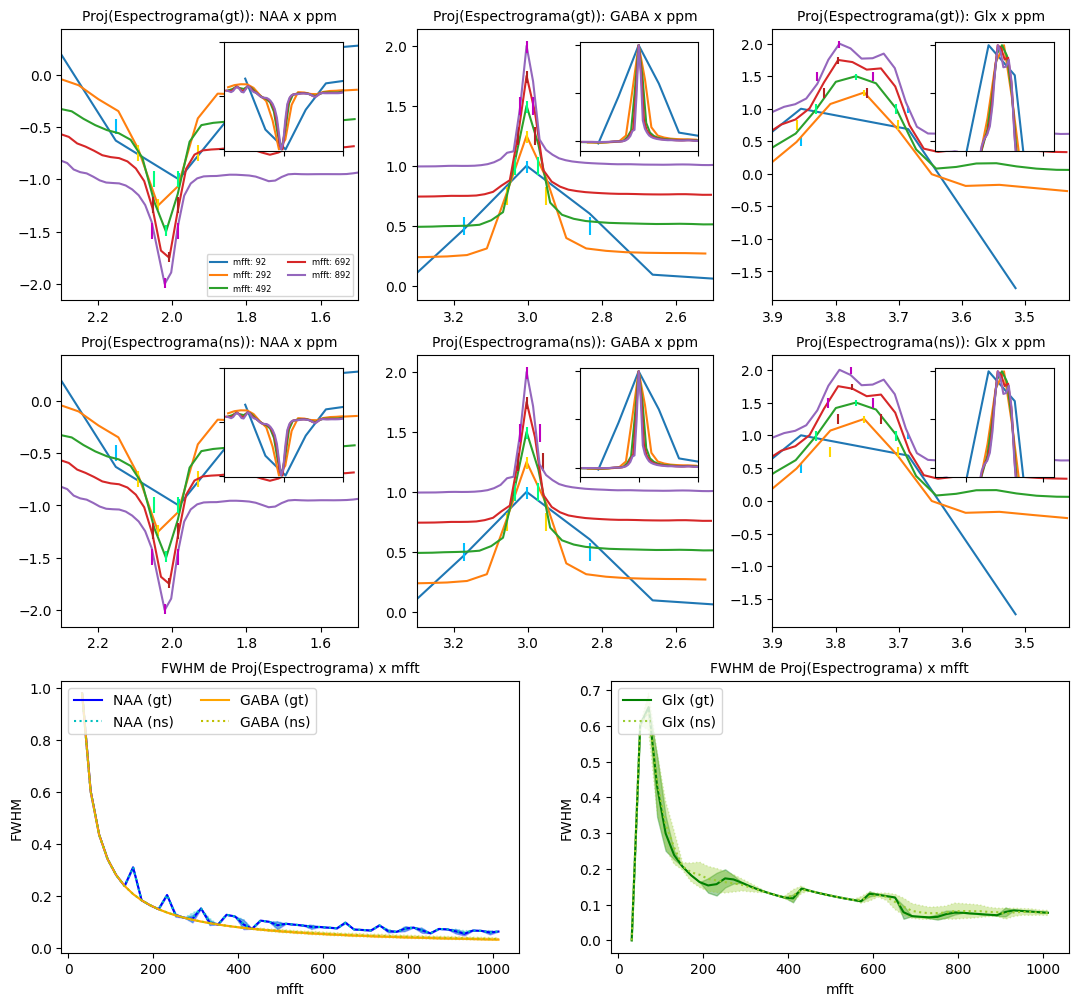

In [24]:
fig = plt.figure(figsize=(13, 12)) 

ax1 = plt.subplot2grid((3, 3), (0, 0))  
ax2 = plt.subplot2grid((3, 3), (0, 1))  
ax3 = plt.subplot2grid((3, 3), (0, 2)) 
ax6 = plt.subplot2grid((3, 3), (1, 0))  
ax7 = plt.subplot2grid((3, 3), (1, 1))  
ax8 = plt.subplot2grid((3, 3), (1, 2)) 

ax4 = plt.subplot2grid((3, 2), (2, 0)) 
ax5 = plt.subplot2grid((3, 2), (2, 1))

axins1 = ax1.inset_axes([0.55, 0.55, 0.4, 0.4],xlim=(2.5,1.5), ylim=(-1.03,1), xticklabels=[], yticklabels=[])
axins2 = ax2.inset_axes([0.55, 0.55, 0.4, 0.4],xlim=(3.5,2.5), ylim=(-0.1,1.03), xticklabels=[], yticklabels=[])
axins3 = ax3.inset_axes([0.55, 0.55, 0.4, 0.4],xlim=(4.2,3.43), ylim=(-0.1,1.03), xticklabels=[], yticklabels=[])
axins6 = ax6.inset_axes([0.55, 0.55, 0.4, 0.4],xlim=(2.5,1.5), ylim=(-1.03,1), xticklabels=[], yticklabels=[])
axins7 = ax7.inset_axes([0.55, 0.55, 0.4, 0.4],xlim=(3.5,2.5), ylim=(-0.1,1.03), xticklabels=[], yticklabels=[])
axins8 = ax8.inset_axes([0.55, 0.55, 0.4, 0.4],xlim=(4.2,3.43), ylim=(-0.1,1.03), xticklabels=[], yticklabels=[])

plot_id = np.arange(3,len(mfft_),10).tolist()
colors = ['#1f77b4','#ff7f0e','#2ca02c','#d62728','#9467bd','#8c564b','#e377c2','#7f7f7f','#bcbd22','#17becf']
colors_sec = ['deepskyblue','gold','springgreen','firebrick','m']
for i in range(5):
    aux = np.mean((np.sum(np.real(spgram_mfft_gt['mfft_'+str(mfft_[plot_id[i]])][0]),axis=2)),axis=0)
    aux_ns = np.mean((np.sum(np.real(spgram_mfft_ns['mfft_'+str(mfft_[plot_id[i]])][0]),axis=2)),axis=0)
    aux1d5 = utils.give_idx_ppm_point(ppm_array=spgram_mfft_gt['mfft_'+str(mfft_[plot_id[i]])][2],ppm_point=1.5)
    aux2d5 = utils.give_idx_ppm_point(ppm_array=spgram_mfft_gt['mfft_'+str(mfft_[plot_id[i]])][2],ppm_point=2.5)
    aux3d5 = utils.give_idx_ppm_point(ppm_array=spgram_mfft_gt['mfft_'+str(mfft_[plot_id[i]])][2],ppm_point=3.5)
    aux4d2 = utils.give_idx_ppm_point(ppm_array=spgram_mfft_gt['mfft_'+str(mfft_[plot_id[i]])][2],ppm_point=4.2)
    aux3d43 = utils.give_idx_ppm_point(ppm_array=spgram_mfft_gt['mfft_'+str(mfft_[plot_id[i]])][2],ppm_point=3.43)
    ax1.plot(np.flip(spgram_mfft_gt['mfft_'+str(mfft_[plot_id[i]])][2])[aux1d5:aux2d5],aux[aux1d5:aux2d5]/np.max(np.abs(aux[aux1d5:aux2d5]))-0.25*i,label='mfft: '+str(mfft_[plot_id[i]]),color=colors[i])
    ax6.plot(np.flip(spgram_mfft_gt['mfft_'+str(mfft_[plot_id[i]])][2])[aux1d5:aux2d5],aux_ns[aux1d5:aux2d5]/np.max(np.abs(aux_ns[aux1d5:aux2d5]))-0.25*i,label='mfft: '+str(mfft_[plot_id[i]]),color=colors[i])
    ax2.plot(np.flip(spgram_mfft_gt['mfft_'+str(mfft_[plot_id[i]])][2])[aux2d5:aux3d5],aux[aux2d5:aux3d5]/np.max(aux[aux2d5:aux3d5])+0.25*i,label='mfft: '+str(mfft_[plot_id[i]]),color=colors[i])
    ax7.plot(np.flip(spgram_mfft_gt['mfft_'+str(mfft_[plot_id[i]])][2])[aux2d5:aux3d5],aux_ns[aux2d5:aux3d5]/np.max(aux_ns[aux2d5:aux3d5])+0.25*i,label='mfft: '+str(mfft_[plot_id[i]]),color=colors[i])
    ax3.plot(np.flip(spgram_mfft_gt['mfft_'+str(mfft_[plot_id[i]])][2])[aux3d43:aux4d2],aux[aux3d43:aux4d2]/np.max(aux[aux3d43:aux4d2])+0.25*i,label='mfft: '+str(mfft_[plot_id[i]]),color=colors[i])
    ax8.plot(np.flip(spgram_mfft_gt['mfft_'+str(mfft_[plot_id[i]])][2])[aux3d43:aux4d2],aux_ns[aux3d43:aux4d2]/np.max(aux_ns[aux3d43:aux4d2])+0.25*i,label='mfft: '+str(mfft_[plot_id[i]]),color=colors[i])
    axins1.plot(np.flip(spgram_mfft_gt['mfft_'+str(mfft_[plot_id[i]])][2])[aux1d5:aux2d5],aux[aux1d5:aux2d5]/np.max(np.abs(aux[aux1d5:aux2d5])),color=colors[i])
    axins6.plot(np.flip(spgram_mfft_gt['mfft_'+str(mfft_[plot_id[i]])][2])[aux1d5:aux2d5],aux_ns[aux1d5:aux2d5]/np.max(np.abs(aux_ns[aux1d5:aux2d5])),color=colors[i])
    axins2.plot(np.flip(spgram_mfft_gt['mfft_'+str(mfft_[plot_id[i]])][2])[aux2d5:aux3d5],aux[aux2d5:aux3d5]/np.max(aux[aux2d5:aux3d5]),color=colors[i])
    axins7.plot(np.flip(spgram_mfft_gt['mfft_'+str(mfft_[plot_id[i]])][2])[aux2d5:aux3d5],aux_ns[aux2d5:aux3d5]/np.max(aux_ns[aux2d5:aux3d5]),color=colors[i])
    axins3.plot(np.flip(spgram_mfft_gt['mfft_'+str(mfft_[plot_id[i]])][2])[aux3d43:aux4d2],aux[aux3d43:aux4d2]/np.max(aux[aux3d43:aux4d2]),color=colors[i])
    axins8.plot(np.flip(spgram_mfft_gt['mfft_'+str(mfft_[plot_id[i]])][2])[aux3d43:aux4d2],aux_ns[aux3d43:aux4d2]/np.max(aux_ns[aux3d43:aux4d2]),color=colors[i])
    aux_NAA = np.mean(idx_fwhm_real_gt['mfft_'+str(mfft_[plot_id[i]])]['NAA'],axis=0)
    ax1.vlines(np.flip(spgram_mfft_gt['mfft_'+str(mfft_[plot_id[i]])][2])[int(aux_NAA[0])],-0.42-0.25*i,-0.57-0.25*i,color=colors_sec[i])
    ax1.vlines(np.flip(spgram_mfft_gt['mfft_'+str(mfft_[plot_id[i]])][2])[int(aux_NAA[1])],-0.42-0.25*i,-0.57-0.25*i,color=colors_sec[i])
    ax1.vlines(np.flip(spgram_mfft_gt['mfft_'+str(mfft_[plot_id[i]])][2])[int(aux_NAA[2])],-0.94-0.25*i,-1.04-0.25*i,color=colors_sec[i])
    aux_GABA = np.mean(idx_fwhm_real_gt['mfft_'+str(mfft_[plot_id[i]])]['GABA'],axis=0)
    ax2.vlines(np.flip(spgram_mfft_gt['mfft_'+str(mfft_[plot_id[i]])][2])[int(aux_GABA[0])],0.42+0.25*i,0.57+0.25*i,color=colors_sec[i])
    ax2.vlines(np.flip(spgram_mfft_gt['mfft_'+str(mfft_[plot_id[i]])][2])[int(aux_GABA[1])],0.42+0.25*i,0.57+0.25*i,color=colors_sec[i])
    ax2.vlines(np.flip(spgram_mfft_gt['mfft_'+str(mfft_[plot_id[i]])][2])[int(aux_GABA[2])],0.94+0.25*i,1.04+0.25*i,color=colors_sec[i])
    aux_Glx = np.mean(idx_fwhm_real_gt['mfft_'+str(mfft_[plot_id[i]])]['Glx'],axis=0)
    ax3.vlines(np.flip(spgram_mfft_gt['mfft_'+str(mfft_[plot_id[i]])][2])[int(aux_Glx[0])],0.42+0.25*i,0.57+0.25*i,color=colors_sec[i])
    ax3.vlines(np.flip(spgram_mfft_gt['mfft_'+str(mfft_[plot_id[i]])][2])[int(aux_Glx[1])],0.42+0.25*i,0.57+0.25*i,color=colors_sec[i])
    ax3.vlines(np.flip(spgram_mfft_gt['mfft_'+str(mfft_[plot_id[i]])][2])[int(aux_Glx[2])],0.94+0.25*i,1.04+0.25*i,color=colors_sec[i])
    aux_NAA = np.mean(idx_fwhm_real_ns['mfft_'+str(mfft_[plot_id[i]])]['NAA'],axis=0)
    ax6.vlines(np.flip(spgram_mfft_ns['mfft_'+str(mfft_[plot_id[i]])][2])[int(aux_NAA[0])],-0.42-0.25*i,-0.57-0.25*i,color=colors_sec[i])
    ax6.vlines(np.flip(spgram_mfft_ns['mfft_'+str(mfft_[plot_id[i]])][2])[int(aux_NAA[1])],-0.42-0.25*i,-0.57-0.25*i,color=colors_sec[i])
    ax6.vlines(np.flip(spgram_mfft_gt['mfft_'+str(mfft_[plot_id[i]])][2])[int(aux_NAA[2])],-0.94-0.25*i,-1.04-0.25*i,color=colors_sec[i])
    aux_GABA = np.mean(idx_fwhm_real_ns['mfft_'+str(mfft_[plot_id[i]])]['GABA'],axis=0)
    ax7.vlines(np.flip(spgram_mfft_ns['mfft_'+str(mfft_[plot_id[i]])][2])[int(aux_GABA[0])],0.42+0.25*i,0.57+0.25*i,color=colors_sec[i])
    ax7.vlines(np.flip(spgram_mfft_ns['mfft_'+str(mfft_[plot_id[i]])][2])[int(aux_GABA[1])],0.42+0.25*i,0.57+0.25*i,color=colors_sec[i])
    ax7.vlines(np.flip(spgram_mfft_gt['mfft_'+str(mfft_[plot_id[i]])][2])[int(aux_GABA[2])],0.94+0.25*i,1.04+0.25*i,color=colors_sec[i])
    aux_Glx = np.mean(idx_fwhm_real_ns['mfft_'+str(mfft_[plot_id[i]])]['Glx'],axis=0)
    ax8.vlines(np.flip(spgram_mfft_ns['mfft_'+str(mfft_[plot_id[i]])][2])[int(aux_Glx[0])],0.42+0.25*i,0.57+0.25*i,color=colors_sec[i])
    ax8.vlines(np.flip(spgram_mfft_ns['mfft_'+str(mfft_[plot_id[i]])][2])[int(aux_Glx[1])],0.42+0.25*i,0.57+0.25*i,color=colors_sec[i])
    ax8.vlines(np.flip(spgram_mfft_gt['mfft_'+str(mfft_[plot_id[i]])][2])[int(aux_Glx[2])],0.94+0.25*i,1.04+0.25*i,color=colors_sec[i])


ax1.set_xlim(2.3,1.5) 
ax2.set_xlim(3.3,2.5)
ax3.set_xlim(3.9,3.43)  
ax1.legend(loc='lower right', ncols=2,fontsize=6)
ax1.set_title('Proj(Espectrograma(gt)): NAA x ppm',fontsize = 10)
ax2.set_title('Proj(Espectrograma(gt)): GABA x ppm',fontsize = 10)
ax3.set_title('Proj(Espectrograma(gt)): Glx x ppm',fontsize = 10)

ax6.set_xlim(2.3,1.5) 
ax7.set_xlim(3.3,2.5)
ax8.set_xlim(3.9,3.43)  
ax6.set_title('Proj(Espectrograma(ns)): NAA x ppm',fontsize = 10)
ax7.set_title('Proj(Espectrograma(ns)): GABA x ppm',fontsize = 10)
ax8.set_title('Proj(Espectrograma(ns)): Glx x ppm',fontsize = 10)


ax4.plot(mfft_,gt_metrics['fwhm_mfft_real']['NAA']['mean'],label='NAA (gt)',color='b')
ax4.fill_between(mfft_, np.array(gt_metrics['fwhm_mfft_real']['NAA']['mean']) - np.array(gt_metrics['fwhm_mfft_real']['NAA']['std']), 
                        np.array(gt_metrics['fwhm_mfft_real']['NAA']['mean']) + np.array(gt_metrics['fwhm_mfft_real']['NAA']['std']), alpha=0.35, color = 'b')
ax4.plot(mfft_,ns_metrics['fwhm_mfft_real']['NAA']['mean'],label='NAA (ns)',color='c',linestyle='dotted')
ax4.fill_between(mfft_, np.array(ns_metrics['fwhm_mfft_real']['NAA']['mean']) - np.array(ns_metrics['fwhm_mfft_real']['NAA']['std']), 
                        np.array(ns_metrics['fwhm_mfft_real']['NAA']['mean']) + np.array(ns_metrics['fwhm_mfft_real']['NAA']['std']), alpha=0.35, color = 'c',linestyle='dotted')
ax4.plot(mfft_,gt_metrics['fwhm_mfft_real']['GABA']['mean'],label='GABA (gt)',color='orange')
ax4.fill_between(mfft_, np.array(gt_metrics['fwhm_mfft_real']['GABA']['mean']) - np.array(gt_metrics['fwhm_mfft_real']['GABA']['std']), 
                        np.array(gt_metrics['fwhm_mfft_real']['GABA']['mean']) + np.array(gt_metrics['fwhm_mfft_real']['GABA']['std']), alpha=0.35, color = 'orange')
ax4.plot(mfft_,ns_metrics['fwhm_mfft_real']['GABA']['mean'],label='GABA (ns)',color='y',linestyle='dotted')
ax4.fill_between(mfft_, np.array(ns_metrics['fwhm_mfft_real']['GABA']['mean']) - np.array(ns_metrics['fwhm_mfft_real']['GABA']['std']), 
                        np.array(ns_metrics['fwhm_mfft_real']['GABA']['mean']) + np.array(ns_metrics['fwhm_mfft_real']['GABA']['std']), alpha=0.35, color = 'y',linestyle='dotted')
ax4.set_title('FWHM de Proj(Espectrograma) x mfft',fontsize = 10)
ax4.set_xlabel('mfft',fontsize = 10)
ax4.set_ylabel('FWHM',fontsize = 10)
ax4.legend(loc='upper left', ncols = 2)
ax5.plot(mfft_,gt_metrics['fwhm_mfft_real']['Glx']['mean'],label='Glx (gt)',color='g')
ax5.fill_between(mfft_, np.array(gt_metrics['fwhm_mfft_real']['Glx']['mean']) - np.array(gt_metrics['fwhm_mfft_real']['Glx']['std']), 
                    np.array(gt_metrics['fwhm_mfft_real']['Glx']['mean']) + np.array(gt_metrics['fwhm_mfft_real']['Glx']['std']), alpha=0.35, color = 'g')
ax5.plot(mfft_,ns_metrics['fwhm_mfft_real']['Glx']['mean'],label='Glx (ns)',color='yellowgreen',linestyle='dotted')
ax5.fill_between(mfft_, np.array(ns_metrics['fwhm_mfft_real']['Glx']['mean']) - np.array(ns_metrics['fwhm_mfft_real']['Glx']['std']), 
                    np.array(ns_metrics['fwhm_mfft_real']['Glx']['mean']) + np.array(ns_metrics['fwhm_mfft_real']['Glx']['std']), alpha=0.35, color = 'yellowgreen',linestyle='dotted')
ax5.set_title('FWHM de Proj(Espectrograma) x mfft',fontsize = 10)
ax5.set_xlabel('mfft',fontsize = 10)
ax5.set_ylabel('FWHM',fontsize = 10)
ax5.legend(loc='upper left')
if test_not_save == False:
    plt.savefig('./relatorio_imagens/imagens_mfft/spgram_varying_mfft_gt_and_noisy_fwhm_real.png')

### 2.5 Padrão de listra dos picos x mfft

Para avaliar se mfft realmente não influencia na listras dos picos, usa-se a métrica ZCR e inspeção visual considerando espectrogramas obtidos com hop = 8 e hop = 20 (para melhor visualização dos picos de Glx e NAA). 

A taxa de cruzamento com zero (ZCR) coincide para espectrogramas gerados de sinais gt e ns. ZCR se mantém praticamente constante para todo valor de mfft. Visualmente, o padrão de listras dos picos não parece se alterar com mfft para hop = 8. Para confirmar tal impressão, gera-se uma imagem de espectrogramas concatenados para hop = 20, onde é mais fácil visualizar as listras dos picos NAA e Glx, pois elas são mais grossas. Nessa outra configuração, também não se observa mudanças no padrão de listras devido a mfft.

Observação: Nota-se, ZCR é medido considerando espectrogramas com hop = 8 APENAS!

In [25]:
aux_concat = (np.arange(19,26)).tolist()
plot_concat = []
for idx in aux_concat:
    plot_concat.append(mfft_[idx])    
spgram_mfft_gt_concat_for_zcr = funcstud.concatenate_different_mfft(list_mfft_idx=plot_concat,spgram_dict=spgram_mfft_gt,time_idx=idx_time_0d4[0],fid_idx_plot=0)

In [26]:
#MFFT FOR HOP 20 FOR BETTER VISUALIZATION !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
mfft_ = np.arange(32,1024,20)
window_ = []
for i in range(mfft_.shape[0]):
    window_.append(hann(int(mfft_[i]),sym=True))
hop_aux = 20
norm_ = 'abs'
spgram_mfft_gt_aux = {}
spgram_mfft_ns_aux = {}
for i in range(mfft_.shape[0]):
    spgram_gt, freq_spect, ppm_spect, t_spect = utils.get_normalized_spectrogram(fids=gt_fids[:1,:,1]-gt_fids[:1,:,0],bandwidth=bandwidth,window=window_[i],mfft=int(mfft_[i]),hop=hop_aux,norm=norm_,correct_time=True,a=a,b=b)
    spgram_mfft_gt_aux['mfft_'+str(mfft_[i])] = [spgram_gt, freq_spect, ppm_spect, t_spect]
    spgram_ns, freq_spect, ppm_spect, t_spect = utils.get_normalized_spectrogram(fids=np.mean(corrupted_fids[:1,:,1,:]-corrupted_fids[:1,:,0,:],axis=2),bandwidth=bandwidth,window=window_[i],mfft=int(mfft_[i]),hop=hop_aux,norm=norm_,correct_time=True,a=a,b=b)
    spgram_mfft_ns_aux['mfft_'+str(mfft_[i])] = [spgram_ns, freq_spect, ppm_spect, t_spect]
list_of_t_spects_aux = []
for i in range(mfft_.shape[0]):
    list_of_t_spects_aux.append(spgram_mfft_gt_aux['mfft_'+str(mfft_[i])][-1])
idx_time_0d4_aux = utils.give_idx_time_point_for_different_time_arrays(list_time_arrays=list_of_t_spects_aux,time_point=0.4)

aux_concat = (np.arange(19,26)).tolist()
plot_concat = []
for idx in aux_concat:
    plot_concat.append(mfft_[idx])    
spgram_mfft_gt_concat_for_zcr_aux = funcstud.concatenate_different_mfft(list_mfft_idx=plot_concat,spgram_dict=spgram_mfft_gt_aux,time_idx=idx_time_0d4_aux[0],fid_idx_plot=0)

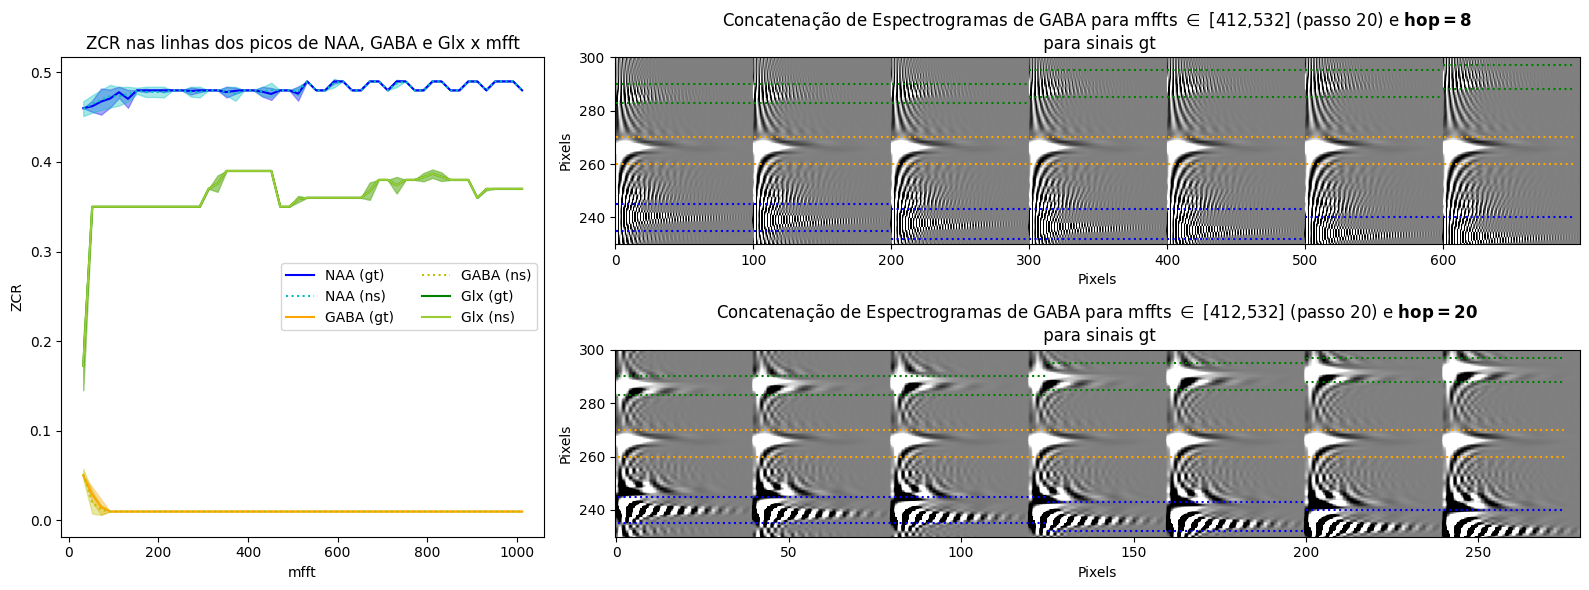

In [27]:
from matplotlib.gridspec import GridSpec
# Create figure and GridSpec
fig = plt.figure(figsize=(16, 6))
gs = GridSpec(2, 2, width_ratios=[1, 2])
ax1 = fig.add_subplot(gs[:, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[1, 1])


ax1.plot(mfft_,gt_metrics['zcr_']['NAA']['mean'],color='b',label='NAA (gt)')
ax1.fill_between(mfft_, np.array(gt_metrics['zcr_']['NAA']['mean']) - np.array(gt_metrics['zcr_']['NAA']['std']), 
                        np.array(gt_metrics['zcr_']['NAA']['mean']) + np.array(gt_metrics['zcr_']['NAA']['std']), alpha=0.35, color = 'b')
ax1.plot(mfft_,ns_metrics['zcr_']['NAA']['mean'],color='c',label='NAA (ns)', linestyle='dotted')
ax1.fill_between(mfft_, np.array(ns_metrics['zcr_']['NAA']['mean']) - np.array(ns_metrics['zcr_']['NAA']['std']), 
                        np.array(ns_metrics['zcr_']['NAA']['mean']) + np.array(ns_metrics['zcr_']['NAA']['std']), alpha=0.35, color = 'c')
ax1.plot(mfft_,gt_metrics['zcr_']['GABA']['mean'],color='orange',label='GABA (gt)')
ax1.fill_between(mfft_, np.array(gt_metrics['zcr_']['GABA']['mean']) - np.array(gt_metrics['zcr_']['GABA']['std']), 
                        np.array(gt_metrics['zcr_']['GABA']['mean']) + np.array(gt_metrics['zcr_']['GABA']['std']), alpha=0.35, color = 'orange')
ax1.plot(mfft_,ns_metrics['zcr_']['GABA']['mean'],color='y',label='GABA (ns)', linestyle='dotted')
ax1.fill_between(mfft_, np.array(ns_metrics['zcr_']['GABA']['mean']) - np.array(ns_metrics['zcr_']['GABA']['std']), 
                        np.array(ns_metrics['zcr_']['GABA']['mean']) + np.array(ns_metrics['zcr_']['GABA']['std']), alpha=0.35, color = 'y')
ax1.plot(mfft_,gt_metrics['zcr_']['Glx']['mean'],color='g',label='Glx (gt)')
ax1.fill_between(mfft_, np.array(gt_metrics['zcr_']['Glx']['mean']) - np.array(gt_metrics['zcr_']['Glx']['std']), 
                        np.array(gt_metrics['zcr_']['Glx']['mean']) + np.array(gt_metrics['zcr_']['Glx']['std']), alpha=0.35, color = 'g')
ax1.plot(mfft_,gt_metrics['zcr_']['Glx']['mean'],color='yellowgreen',label='Glx (ns)')
ax1.fill_between(mfft_, np.array(gt_metrics['zcr_']['Glx']['mean']) - np.array(gt_metrics['zcr_']['Glx']['std']), 
                        np.array(gt_metrics['zcr_']['Glx']['mean']) + np.array(gt_metrics['zcr_']['Glx']['std']), alpha=0.35, color = 'yellowgreen')
ax1.legend(loc='center right',ncols=2)
ax1.set_title('ZCR nas linhas dos picos de NAA, GABA e Glx x mfft')
ax1.set_ylabel('ZCR')
ax1.set_xlabel('mfft')

ax2.imshow(np.real(spgram_mfft_gt_concat_for_zcr),vmax = 0.04,vmin = -0.04,aspect='auto',cmap='gray',origin='lower')
ax2.set_ylim(230,300)
ax2.set_xlabel('Pixels')
ax2.set_ylabel('Pixels')
ax2.set_title('Concatenação de Espectrogramas de GABA para mffts $\in$ [412,532] (passo 20) e $\mathbf{hop = 8}$ \n para sinais gt')

ax3.imshow(np.real(spgram_mfft_gt_concat_for_zcr_aux),vmax = 0.04,vmin = -0.04,aspect='auto',cmap='gray',origin='lower')
ax3.set_ylim(230,300)
ax3.set_xlabel('Pixels')
ax3.set_ylabel('Pixels')
ax3.set_title('Concatenação de Espectrogramas de GABA para mffts $\in$ [412,532] (passo 20) e $\mathbf{hop = 20}$ \n para sinais gt')

ax2.hlines(235,0.5,200,color='b',linestyle='dotted')
ax2.hlines(245,0.5,200,color='b',linestyle='dotted')
ax2.hlines(232,200,500,color='b',linestyle='dotted')
ax2.hlines(243,200,500,color='b',linestyle='dotted')
ax2.hlines(240,500,695,color='b',linestyle='dotted')

ax3.hlines(235,0.5,125,color='b',linestyle='dotted')
ax3.hlines(245,0.5,125,color='b',linestyle='dotted')
ax3.hlines(232,125,200,color='b',linestyle='dotted')
ax3.hlines(243,125,200,color='b',linestyle='dotted')
ax3.hlines(240,200,275,color='b',linestyle='dotted')

ax2.hlines(260,0.5,695,color='orange',linestyle='dotted')
ax2.hlines(270,0.5,695,color='orange',linestyle='dotted')

ax3.hlines(260,0.5,275,color='orange',linestyle='dotted')
ax3.hlines(270,0.5,275,color='orange',linestyle='dotted')


ax2.hlines(283,0.5,300,color='g',linestyle='dotted')
ax2.hlines(290,0.5,300,color='g',linestyle='dotted')
ax2.hlines(285,300,600,color='g',linestyle='dotted')
ax2.hlines(295,300,600,color='g',linestyle='dotted')
ax2.hlines(288,600,695,color='g',linestyle='dotted')
ax2.hlines(297,600,695,color='g',linestyle='dotted')

ax3.hlines(283,0.5,125,color='g',linestyle='dotted')
ax3.hlines(290,0.5,125,color='g',linestyle='dotted')
ax3.hlines(285,125,200,color='g',linestyle='dotted')
ax3.hlines(295,125,200,color='g',linestyle='dotted')
ax3.hlines(288,200,275,color='g',linestyle='dotted')
ax3.hlines(297,200,275,color='g',linestyle='dotted')

plt.tight_layout()
if test_not_save == False:
    plt.savefig('./relatorio_imagens/imagens_mfft/spgram_varying_mfft_gt_and_noisy_zcr.png')

### 2.6 Figura Resumo

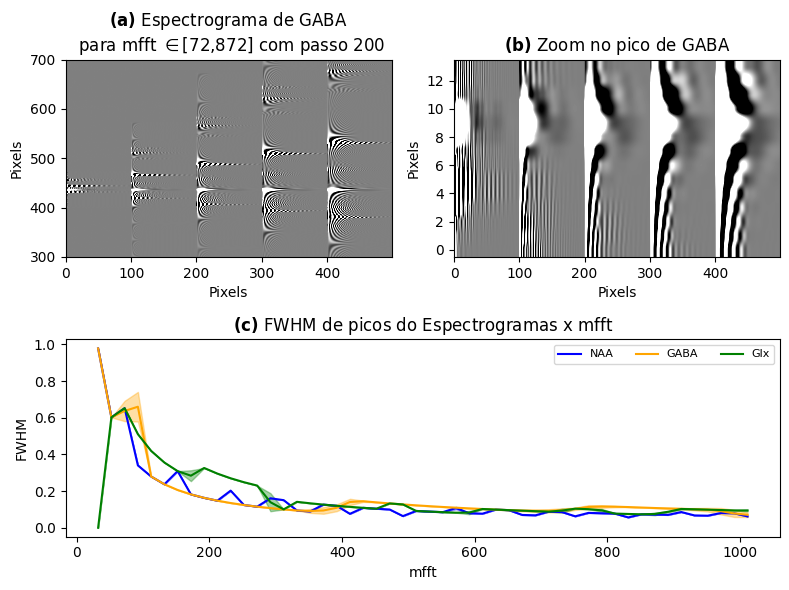

In [17]:
fig = plt.figure(figsize=(8, 6))
gs = gridspec.GridSpec(2, 2)
ax1 = fig.add_subplot(gs[0,0])  
ax2 = fig.add_subplot(gs[0,1]) 
ax3 = fig.add_subplot(gs[1,:]) 

center = spgram_mfft_gt_concat.shape[0]/2
aux = spgram_mfft_gt['mfft_'+str(mfft_[2])][0].shape[1]
ax1.imshow(np.real(spgram_mfft_gt_concat), origin='lower',cmap='gray',aspect='auto',vmin=-0.03,vmax=0.03)
ax1.set_ylim(300,700)
ax2.imshow(np.real(spgram_mfft_gt_concat[int(center)-int(aux/2)+idx_freq_1ppm[2]:int(center)-int(aux/2)+idx_freq_4ppm[2],:]), origin='lower', 
             aspect='auto',cmap='gray',vmin=-0.01,vmax=0.01)
ax3.plot(mfft_,gt_metrics['fwhm_mfft']['NAA']['mean'],label='NAA',color='b')
ax3.fill_between(mfft_, np.array(gt_metrics['fwhm_mfft']['NAA']['mean']) - np.array(gt_metrics['fwhm_mfft']['NAA']['std']), 
                        np.array(gt_metrics['fwhm_mfft']['NAA']['mean']) + np.array(gt_metrics['fwhm_mfft']['NAA']['std']), alpha=0.35, color = 'b')
ax3.plot(mfft_,gt_metrics['fwhm_mfft']['GABA']['mean'],label='GABA',color='orange')
ax3.fill_between(mfft_, np.array(gt_metrics['fwhm_mfft']['GABA']['mean']) - np.array(gt_metrics['fwhm_mfft']['GABA']['std']), 
                        np.array(gt_metrics['fwhm_mfft']['GABA']['mean']) + np.array(gt_metrics['fwhm_mfft']['GABA']['std']), alpha=0.35, color = 'orange')
ax3.plot(mfft_,gt_metrics['fwhm_mfft']['Glx']['mean'],label='Glx',color='g')
ax3.fill_between(mfft_, np.array(gt_metrics['fwhm_mfft']['Glx']['mean']) - np.array(gt_metrics['fwhm_mfft']['Glx']['std']), 
                        np.array(gt_metrics['fwhm_mfft']['Glx']['mean']) + np.array(gt_metrics['fwhm_mfft']['Glx']['std']), alpha=0.35, color = 'g')
ax1.set_title('$\mathbf{(a)}$ Espectrograma de GABA \n para mfft $\in $[72,872] com passo 200',fontsize=12)
ax1.set_ylabel('Pixels',fontsize=10)
ax1.set_xlabel('Pixels',fontsize=10)
ax2.set_title('$\mathbf{(b)}$ Zoom no pico de GABA',fontsize=12)
ax2.set_ylabel('Pixels',fontsize=10)
ax2.set_xlabel('Pixels',fontsize=10)
ax3.set_title("$\mathbf{(c)}$ FWHM de picos do Espectrogramas x mfft",fontsize=12)
ax3.set_ylabel('FWHM',fontsize=10)
ax3.set_xlabel('mfft',fontsize=10)
ax3.legend(loc='upper right', ncols=3,fontsize=8)
plt.tight_layout()
if test_not_save == False:
    plt.savefig('results_mfft.png')